## Preprocessing

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import json
import time
import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Let's define the hyperparameters and complete the necessary preprocessing steps.

In [5]:
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1
TIME_WINDOW_SIZE = 12
EPOCHS = 200

NUMBER_OF_CLIENTS = 50 # Controls the number of households used for forecasting.

In [3]:
def prepare_weather():
  weather = pd.read_csv('weather.csv', parse_dates=[3])
  weather = weather[weather['time'].dt.strftime('%Y') == '2013'].sort_values(by=['time'])
  weather = weather.set_index('time')
  weather = weather[['temperature', 'humidity']]
  return weather

def load_data():
    df = pd.read_csv('combined.csv', parse_dates=[1])
    return df

def basic_preprocess_fn(df:pd.DataFrame):
    """ Selects the electricity data with standard tariffs belonging to year 2013 and sorts the dataframe based on 
    DateTime column. """
    
    temp = df[df['DateTime'].dt.strftime('%Y') == '2013'].sort_values(by=['DateTime'])
    #temp = temp[temp['stdorToU'] == 'Std']
    #temp = temp.drop(axis=1, columns = 'stdorToU')
    return temp

def extract_clients(df:pd.DataFrame):
    """ Extracts client ids and client data from the given dataframe, which is assumed to hold multiple 
    client information."""
    
    client_keys = df['LCLid'].value_counts().keys().tolist()
    client_list = []

    for key in client_keys:
        client_df = df[df['LCLid'] == key]
        client_list.append(client_df)

    return client_keys, client_list

def resample_fn(df:pd.DataFrame):
    """ Resamples the time-series dataframe so that it reflects hourly electricity consumption values. It also does
    basic data processing such as dropping unnecessary columns. """
    
    resample_df = df.astype({"KWH/hh (per half hour) ": float}).drop(columns = ['LCLid']).set_index('DateTime').resample(rule='H').sum()
    resample_df.rename(columns = {'KWH/hh (per half hour) ':'kWh'}, inplace = True)
    return resample_df

def remove_bad_clients(client_keys:list, client_list:list):
    """ Drops the clients with datapoints fewer than 0.9 percent of the client with highest amount of data. """
    
    sizes = [len(e) for e in client_list]
    biggest_client = max(sizes) 
    ratios = [size/biggest_client for size in sizes]
    indices_to_keep = [idx for idx,e in enumerate(ratios) if e==1]
    
    client_keys_selected = [client_keys[index] for index in indices_to_keep]
    client_list_selected = [client_list[index] for index in indices_to_keep]
    
    return client_keys_selected, client_list_selected

def create_client_dict(client_keys, client_data_list):
    """ Matches every client ID with its own electricty consumption data and returns the pairs in a python dictionary. """
    client_dict = {}
    for key, df in zip(client_keys, client_data_list):
        client_dict[key] = df
        
    return client_dict

In [4]:
df = load_data()
temp = basic_preprocess_fn(df)
client_keys, client_list = extract_clients(temp)
client_list_resampled = list(map(resample_fn, client_list))
client_keys_selected, client_list_selected = remove_bad_clients(client_keys, client_list_resampled)
client_dict = create_client_dict(client_keys_selected, client_list_selected)
weather = prepare_weather()

We can now sample some households(clients) from all the available ones.

In [7]:
random.seed(10)
shortlist_keys = random.sample(list(client_dict.keys()), NUMBER_OF_CLIENTS)
print(shortlist_keys)

['MAC001845', 'MAC002197', 'MAC002165', 'MAC002170', 'MAC001356', 'MAC002189', 'MAC001362', 'MAC001818', 'MAC001280', 'MAC001841', 'MAC001295', 'MAC001272', 'MAC001294', 'MAC001821', 'MAC001817', 'MAC001266', 'MAC001353', 'MAC001361', 'MAC004473', 'MAC001377', 'MAC001829', 'MAC001815', 'MAC001842', 'MAC004478', 'MAC001268', 'MAC001813', 'MAC002178', 'MAC001365', 'MAC002179', 'MAC001368', 'MAC004460', 'MAC001812', 'MAC002196', 'MAC004483', 'MAC004482', 'MAC002194', 'MAC001811', 'MAC002181', 'MAC001837', 'MAC004475', 'MAC004459', 'MAC001289', 'MAC001302', 'MAC001822', 'MAC002184', 'MAC001852', 'MAC002191', 'MAC001263', 'MAC001843', 'MAC001276']


In [9]:
t = pd.DataFrame()
for k,v in client_dict.items():
  if k in shortlist_keys:
    t[k] = v

t_new = t.copy()
display(t_new)

MAC001302  MAC002170  MAC001266  MAC001845  MAC004473  \
DateTime                                                                     
2013-01-01 00:00:00      0.168      0.342      0.207      0.065      0.879   
2013-01-01 01:00:00      0.058      0.163      0.061      0.070      0.847   
2013-01-01 02:00:00      0.100      0.152      0.023      0.145      0.756   
2013-01-01 03:00:00      0.053      0.152      0.024      0.059      0.679   
2013-01-01 04:00:00      0.017      0.208      0.024      0.061      0.595   
...                        ...        ...        ...        ...        ...   
2013-12-31 19:00:00      0.378      0.267      0.839      0.165      0.213   
2013-12-31 20:00:00      0.426      0.317      1.401      0.159      0.180   
2013-12-31 21:00:00      0.772      0.312      1.641      0.158      0.103   
2013-12-31 22:00:00      0.405      0.184      1.984      0.159      0.096   
2013-12-31 23:00:00      0.423      0.514      2.115      0.155      0.339   

                     MAC001294  MAC002179  MAC001852  MAC001811  MAC002178  \
DateTime                                                                     
2013-01-01 00:00:00      0.019      0.151      0.056      0.841      0.224   
2013-01-01 01:00:00      0.034      0.153      0.055      0.094      0.176   
2013-01-01 02:00:00      0.042      0.152      0.056      1.303      0.066   
2013-01-01 03:00:00      0.019      0.161      0.055      0.571      0.071   
2013-01-01 04:00:00      0.057      0.134      0.055      0.114      0.088   
...                        ...        ...        ...        ...        ...   
2013-12-31 19:00:00      0.319      0.365      0.169      0.630      0.389   
2013-12-31 20:00:00      0.357      0.359      0.185      0.632      0.688   
2013-12-31 21:00:00      0.243      0.375      0.277      0.495      1.385   
2013-12-31 22:00:00      0.377      0.336      0.258      1.261      0.893   
2013-12-31 23:00:00      0.264      0.319      0.134      0.211      0.803   

                     ...  MAC002189  MAC004475  MAC002165  MAC001362  \
DateTime             ...                                               
2013-01-01 00:00:00  ...      0.097      0.943      2.146      0.104   
2013-01-01 01:00:00  ...      0.100      0.126      2.207      0.022   
2013-01-01 02:00:00  ...      0.098      0.105      2.243      0.031   
2013-01-01 03:00:00  ...      0.099      0.076      0.918      0.037   
2013-01-01 04:00:00  ...      0.098      0.095      0.346      0.041   
...                  ...        ...        ...        ...        ...   
2013-12-31 19:00:00  ...      0.519      0.289      0.290      0.207   
2013-12-31 20:00:00  ...      0.511      1.682      0.208      0.187   
2013-12-31 21:00:00  ...      0.541      1.672      0.230      0.082   
2013-12-31 22:00:00  ...      0.464      1.618      0.261      0.077   
2013-12-31 23:00:00  ...      0.494      1.204      0.260      0.060   

                     MAC004459  MAC001842  MAC001295  MAC004483  MAC001843  \
DateTime                                                                     
2013-01-01 00:00:00      0.307      0.429      0.143      0.049      0.675   
2013-01-01 01:00:00      0.258      0.459      0.178      0.218      0.608   
2013-01-01 02:00:00      0.497      0.364      0.189      0.104      0.737   
2013-01-01 03:00:00      0.644      0.375      0.185      0.106      0.621   
2013-01-01 04:00:00      0.708      0.276      0.150      0.109      0.592   
...                        ...        ...        ...        ...        ...   
2013-12-31 19:00:00      1.595      0.709      0.710      0.682      1.388   
2013-12-31 20:00:00      3.030      0.485      0.652      0.634      0.962   
2013-12-31 21:00:00      3.216      0.558      0.672      0.117      0.659   
2013-12-31 22:00:00      2.728      0.658      0.637      0.136      0.609   
2013-12-31 23:00:00      0.788      0.878      0.506      0.114      0.849   

                     MAC001841  
DateTi

Uncomment the lines below if you'd like to use weather and datetime features in addition to the energy consumption data. Adding them did not improve the results significantly, so I decided to ignore them eventually.

In [11]:
#t_new['temperature'] = weather['temperature']
#t_new['humidity'] = weather['humidity']

t_new = t_new[:4380] # Using half of the available data to save computing power, since the corresponding FL simulations were too hungry for RAM.

#t_new['hour'] = t_new.index.hour
#t_new['day_of_week'] = t_new.index.dayofweek
#t_new['week_of_year'] = t_new.index.isocalendar().week

display(t_new)

MAC001302  MAC002170  MAC001266  MAC001845  MAC004473  \
DateTime                                                                     
2013-01-01 00:00:00      0.168      0.342      0.207      0.065      0.879   
2013-01-01 01:00:00      0.058      0.163      0.061      0.070      0.847   
2013-01-01 02:00:00      0.100      0.152      0.023      0.145      0.756   
2013-01-01 03:00:00      0.053      0.152      0.024      0.059      0.679   
2013-01-01 04:00:00      0.017      0.208      0.024      0.061      0.595   
...                        ...        ...        ...        ...        ...   
2013-07-02 07:00:00      0.095      0.463      0.338      0.077      0.431   
2013-07-02 08:00:00      0.153      0.132      0.077      0.198      0.121   
2013-07-02 09:00:00      0.082      0.480      0.076      0.309      0.147   
2013-07-02 10:00:00      0.106      0.269      0.078      0.229      0.177   
2013-07-02 11:00:00      0.071      0.239      0.170      0.204      0.125   

                     MAC001294  MAC002179  MAC001852  MAC001811  MAC002178  \
DateTime                                                                     
2013-01-01 00:00:00      0.019      0.151      0.056      0.841      0.224   
2013-01-01 01:00:00      0.034      0.153      0.055      0.094      0.176   
2013-01-01 02:00:00      0.042      0.152      0.056      1.303      0.066   
2013-01-01 03:00:00      0.019      0.161      0.055      0.571      0.071   
2013-01-01 04:00:00      0.057      0.134      0.055      0.114      0.088   
...                        ...        ...        ...        ...        ...   
2013-07-02 07:00:00      0.027      0.326      0.046      0.159      0.137   
2013-07-02 08:00:00      0.052      0.175      0.048      0.249      0.304   
2013-07-02 09:00:00      0.029      0.165      0.051      0.186      0.243   
2013-07-02 10:00:00      0.048      0.184      0.047      0.462      0.546   
2013-07-02 11:00:00      0.032      0.177      0.045      0.508      0.720   

                     ...  MAC002189  MAC004475  MAC002165  MAC001362  \
DateTime             ...                                               
2013-01-01 00:00:00  ...      0.097      0.943      2.146      0.104   
2013-01-01 01:00:00  ...      0.100      0.126      2.207      0.022   
2013-01-01 02:00:00  ...      0.098      0.105      2.243      0.031   
2013-01-01 03:00:00  ...      0.099      0.076      0.918      0.037   
2013-01-01 04:00:00  ...      0.098      0.095      0.346      0.041   
...                  ...        ...        ...        ...        ...   
2013-07-02 07:00:00  ...      0.233      0.204      1.392      0.119   
2013-07-02 08:00:00  ...      0.150      0.073      0.305      0.592   
2013-07-02 09:00:00  ...      0.151      0.094      0.269      0.258   
2013-07-02 10:00:00  ...      0.152      0.093      0.304      0.011   
2013-07-02 11:00:00  ...      0.148      0.087      0.273      0.138   

                     MAC004459  MAC001842  MAC001295  MAC004483  MAC001843  \
DateTime                                                                     
2013-01-01 00:00:00      0.307      0.429      0.143      0.049      0.675   
2013-01-01 01:00:00      0.258      0.459      0.178      0.218      0.608   
2013-01-01 02:00:00      0.497      0.364      0.189      0.104      0.737   
2013-01-01 03:00:00      0.644      0.375      0.185      0.106      0.621   
2013-01-01 04:00:00      0.708      0.276      0.150      0.109      0.592   
...                        ...        ...        ...        ...        ...   
2013-07-02 07:00:00      0.973      0.212      0.134      0.059      0.663   
2013-07-02 08:00:00      0.958      0.155      1.507      0.075      0.404   
2013-07-02 09:00:00      0.473      0.222      0.495      0.064      0.452   
2013-07-02 10:00:00      0.359      0.185      0.313      0.055      0.401   
2013-07-02 11:00:00      0.419      0.196      1.674      0.050      0.432   

                     MAC001841  
DateTi

## Creating Tensors

We have the dataset ready, now we can focus on splitting and normalizing it. We will then create the corresponding tensors.

In [12]:
def train_test_val_split(df):
  """ Splits the client data into train, test and validation datasets. """

  df_size = df.shape[0]

  train = df.iloc[:int(df_size * 0.7)]
  val = df.iloc[int(df_size * 0.7):int(df_size * 0.9)]
  test = df.iloc[int(df_size * 0.9):]

  return train, val, test

def normalize_fn(train, val, test, scaler = MinMaxScaler()):
  """ Normalizes the input arrays with the given scaler. Train array is taken as the reference. """
  #energy_columns = list(t_new.columns[:-5].values)

  #train[energy_columns] = scaler.fit_transform( train[energy_columns].values )
  #val[energy_columns] = scaler.transform( val[energy_columns].values )
  #test[energy_columns] = scaler.transform( test[energy_columns].values )

  train_sc = scaler.fit_transform( train.values )
  val_sc = scaler.transform( val.values )
  test_sc = scaler.transform( test.values )
  scaler = scaler
  
  return train_sc, val_sc, test_sc, scaler

In [13]:
train, val, test = train_test_val_split(t_new)

In [14]:
train_sc, val_sc, test_sc, scaler = normalize_fn(train, val, test)

In [16]:
def create_tensor_datasets(train_sc, val_sc, test_sc):
  """ Applies the window function on the scaled train,test and validation arrays. Output will be tf.data datasets."""
  
  def window_fn(input_array, window_size=TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE):
      """ Creates time series windows for the given input array and returns them as a batch of tensorflow dataset."""
      dataset = tf.data.Dataset.from_tensor_slices(input_array)
      dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      dataset = dataset.map(lambda window: (window[:-1], window[-1:, :NUMBER_OF_CLIENTS]), num_parallel_calls=10)
      dataset = dataset.batch(batch_size, num_parallel_calls=10).prefetch(1)

      return dataset

  train_tf = window_fn(train_sc, window_size = TIME_WINDOW_SIZE)
  val_tf = window_fn(val_sc, window_size = TIME_WINDOW_SIZE)
  test_tf = window_fn(test_sc, window_size = TIME_WINDOW_SIZE)
  #dataset_tf = window_fn(df, window_size=12)

  return train_tf, val_tf, test_tf

In [17]:
train_tf, val_tf, test_tf = create_tensor_datasets(train_sc, val_sc, test_sc)

Let us do a simple check before training to see if the shapes of our datasets are correct. The shapes will come in the form of (Batch_Size, Time_Window_Size, Number_of_Features). We used the same batch size for all the data, so the first dimension should be equal to TRAIN_BATCH_SIZE hyperparameter. Number of features here should be equal to number of clients if you are using only the raw energy consumption data. Time window size is defined in the beginning of this notebook.

In [19]:
for x, y in train_tf.take(1):
  print('Shape of train tensors:', x.shape, y.shape)

for x, y in val_tf.take(1):
  print('Shape of validation tensors:', x.shape, y.shape)

for x, y in test_tf.take(1):
  print('Shape of test tensors:', x.shape, y.shape)

Shape of train tensors: (512, 12, 50) (512, 1, 50)
Shape of validation tensors: (512, 12, 50) (512, 1, 50)
Shape of test tensors: (426, 12, 50) (426, 1, 50)


## Training

This section is quite self-explanatory. We will create the necessary functions for running the training and then start the procedure itself. We will be using a patience value of 20 for Early Stopping.

In [20]:
def create_model():
  """ Initialize an LSTM model."""
  model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape=(None,12,train.shape[1]), return_sequences=True),
  tf.keras.layers.LSTM(16, dropout=0.1),
  tf.keras.layers.Dense(train.shape[1]),
  ])
  return model

def train_fn(model, train_tf, val_tf, lr = 0.002, opt = tf.keras.optimizers.Adam, epochs = EPOCHS):
  """ Fits the model on train&validation data and returns the corresponding MSE loss values. """
  model = model
  train = train_tf
  validation = val_tf
  
  learning_rate = lr
  optimizer = opt(learning_rate = lr)
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=optimizer,
            metrics=["mse"])

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
  history = model.fit(x=train, epochs=epochs, validation_data=validation, callbacks=[callback], verbose=False)
  val_loss = history.history['val_loss']
  train_loss = history.history['loss']
  return train_loss, val_loss

In [21]:
model = create_model()

train_loss, val_losses = train_fn(model, train_tf, val_tf)

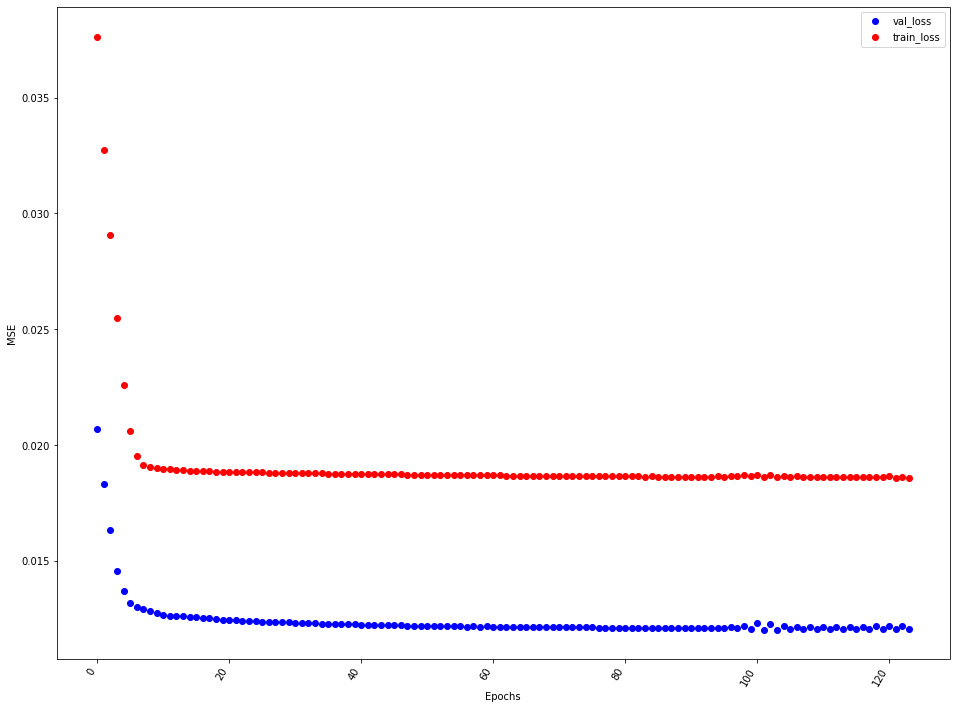

In [22]:
x_ax = [i for i in range(len(val_losses))]
mpl.rcParams['figure.figsize'] = (16, 12)

plt.scatter(x=x_ax, y=val_losses, color = 'b',label='val_loss')
plt.scatter(x=x_ax, y=train_loss, color = 'r', label='train_loss')
plt.xticks(rotation=60, ha='right')
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Evaluation

The model is now trained and we can evaluate its performance on the test set.

In [23]:
def evaluate(model, scaler, test_tf, test):
  """ Evaluate the trained local model on local test set, return predicstions and test MSE."""

  forecast = pd.DataFrame(model.predict(test_tf))
  #residue = pd.DataFrame(test_sc).iloc[TIME_WINDOW_SIZE: , NUMBER_OF_CLIENTS:].reset_index(drop=True)
  #final_df = pd.concat([forecast, residue], join='inner', axis = 1)

  predictions = scaler.inverse_transform(forecast)
  pred_df = pd.DataFrame(data = predictions, columns = list(test.columns.values), index = test[TIME_WINDOW_SIZE:].index)
  #print(pred_df)
  #print()
  #print(test)
  #print(pred_df.iloc[: , :NUMBER_OF_CLIENTS])
  #print(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS])
  test_metrics = round(mean_squared_error(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)
  test_metrics_pct = round(mean_absolute_percentage_error(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)
  r2 = round(r2_score(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)

  return pred_df, test_metrics, test_metrics_pct, r2

In [24]:
preds, mse, mape, r2 = evaluate(model, scaler, test_tf, test)

Let's print some evaluation metrics.

In [25]:
print('Mean Square Error:', mse)
print('R-Squared Value:', r2)

Mean Square Error: 0.11626
R-Squared Value: -0.17492


Let us also plot out the forecasting results to understand them visually. We will first show the result of one randomly selected house as a reference for our other experiments, then show the results for every house.

In [26]:
random.seed(10)
random_key = random.sample(shortlist_keys, 1)
print(random_key)

['MAC001811']


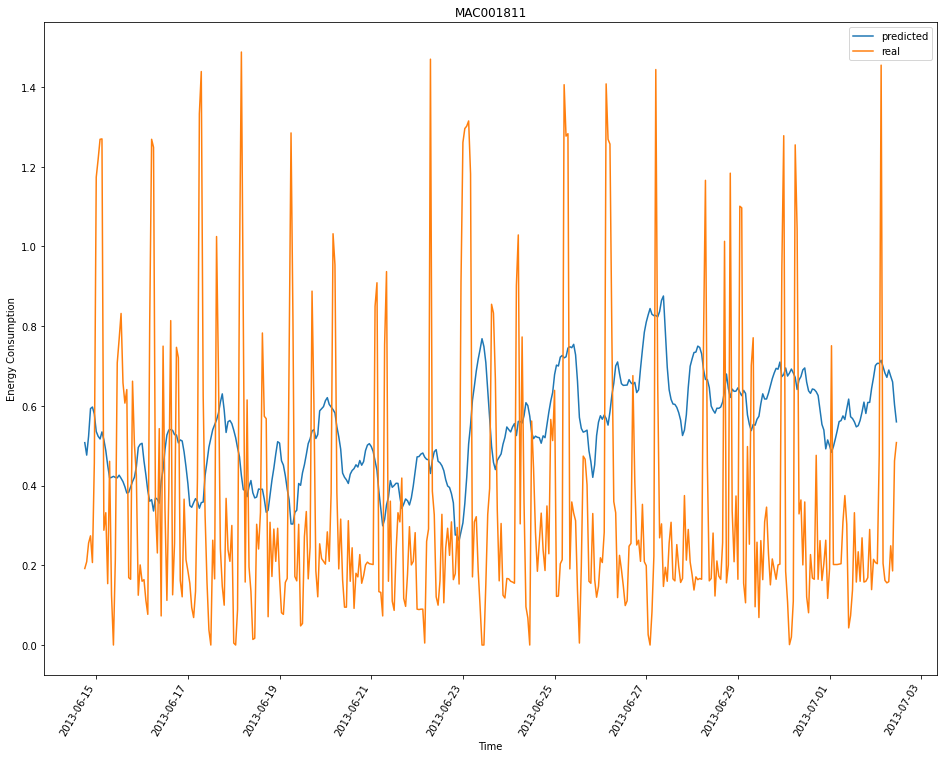

In [27]:
#random_number = random.randint(0,NUMBER_OF_CLIENTS)
random_pred = preds[random_key]
random_true = test.iloc[TIME_WINDOW_SIZE:][random_key]

x_ax = list(preds.index)
mpl.rcParams['figure.figsize'] = (16, 12)

plt.plot(x_ax, random_pred, label='predicted')
plt.plot(x_ax, random_true, label='real')
plt.xticks(rotation=60, ha='right')
plt.ylabel("Energy Consumption")
plt.xlabel("Time")
plt.title(random_key[0])
plt.legend()
plt.show()
plt.close()

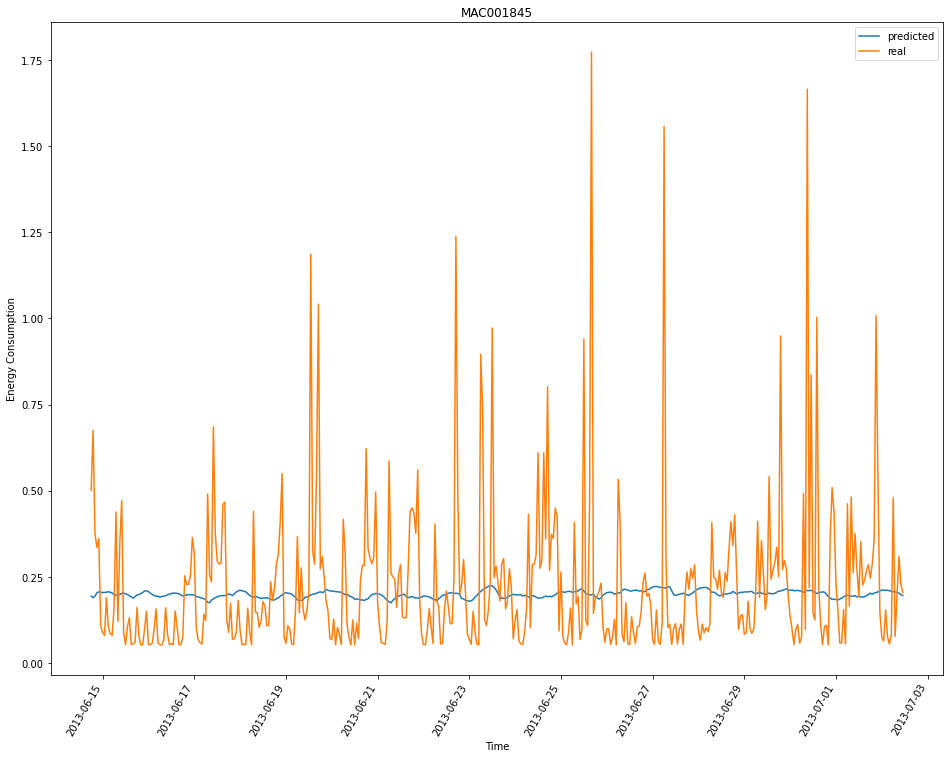

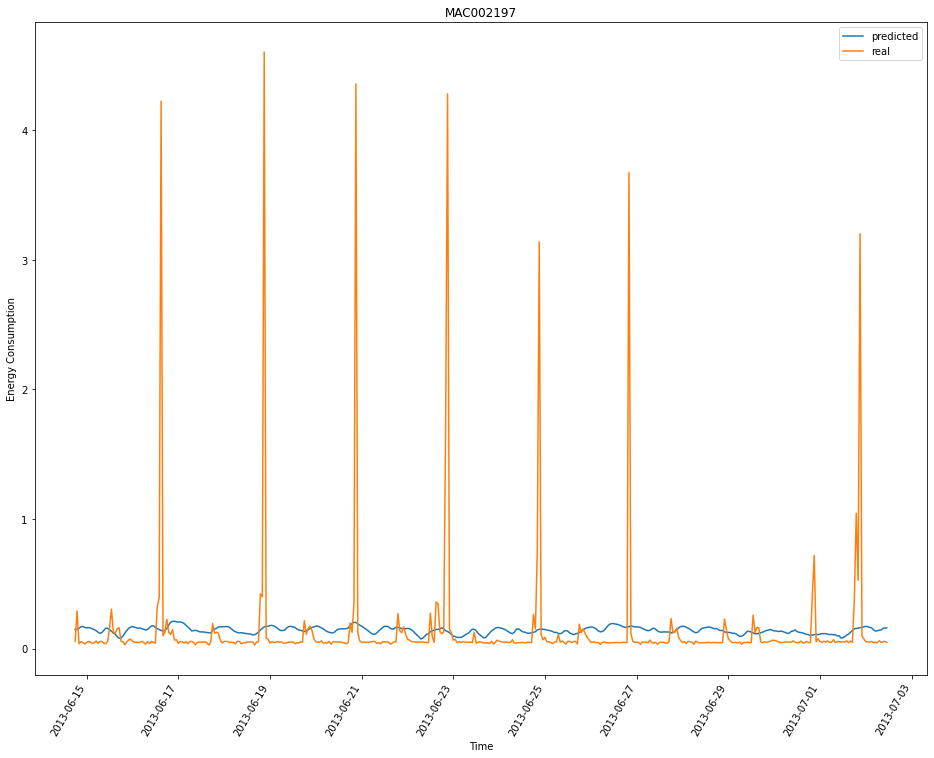

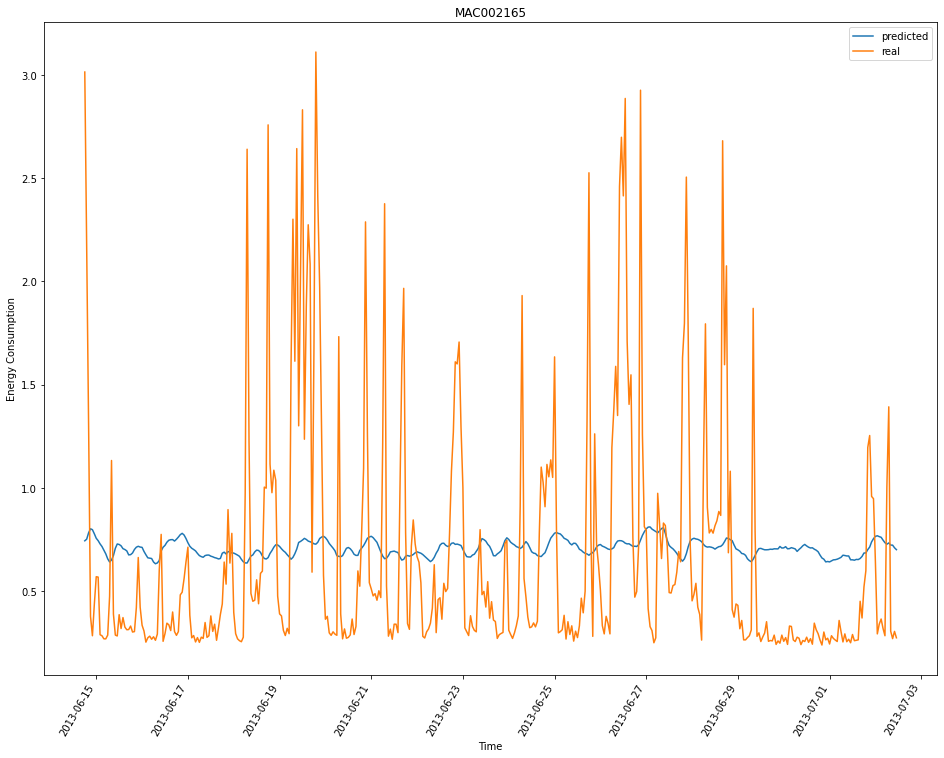

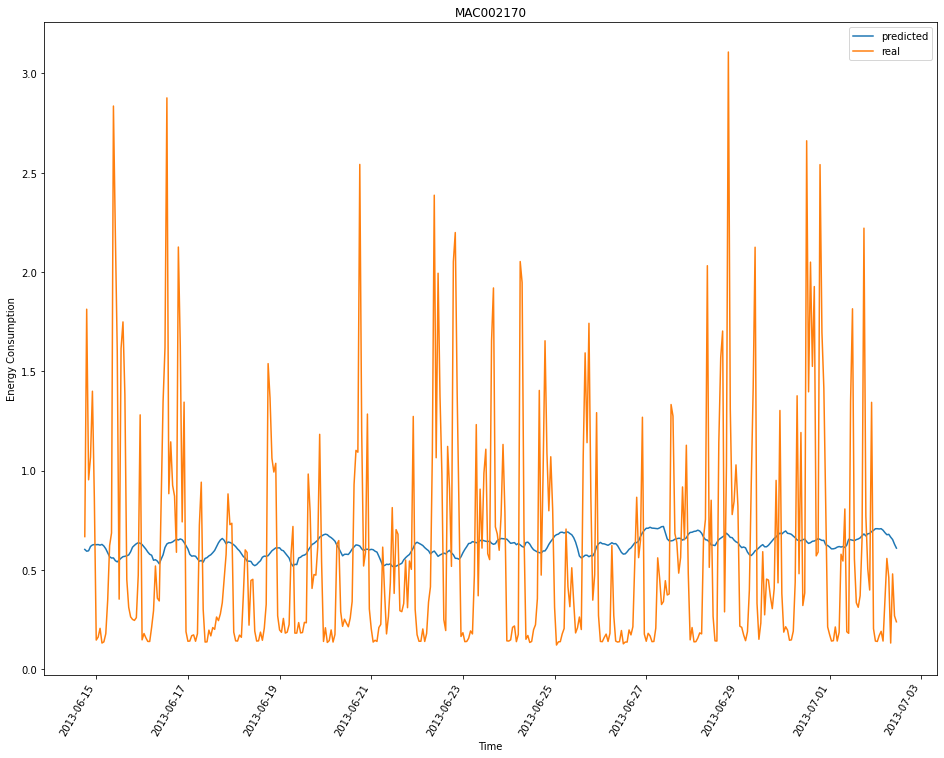

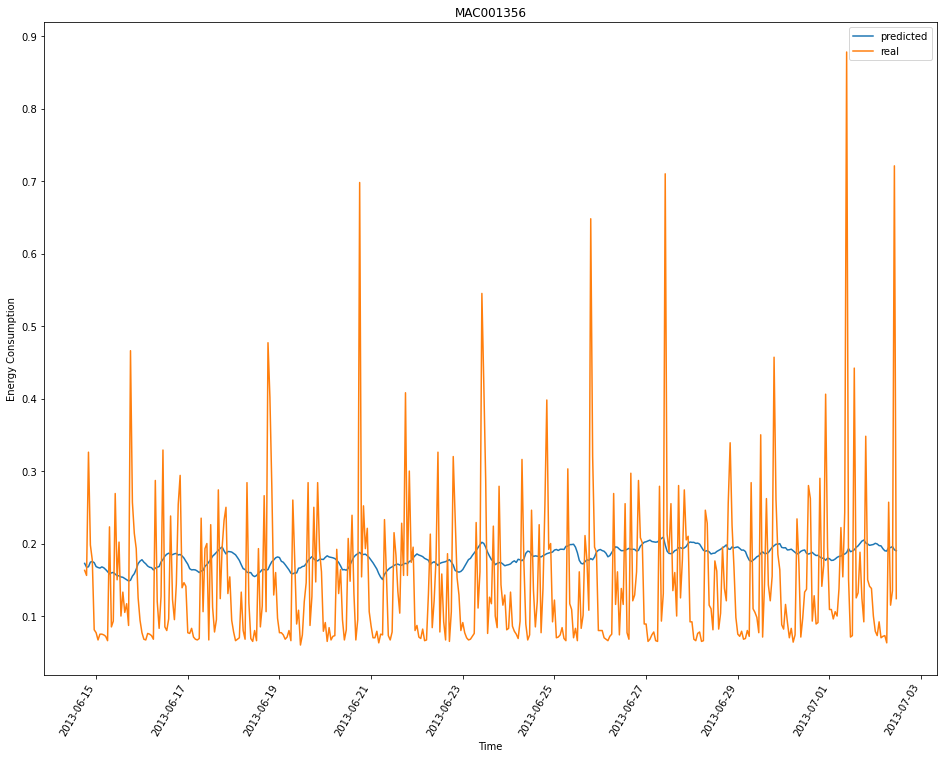

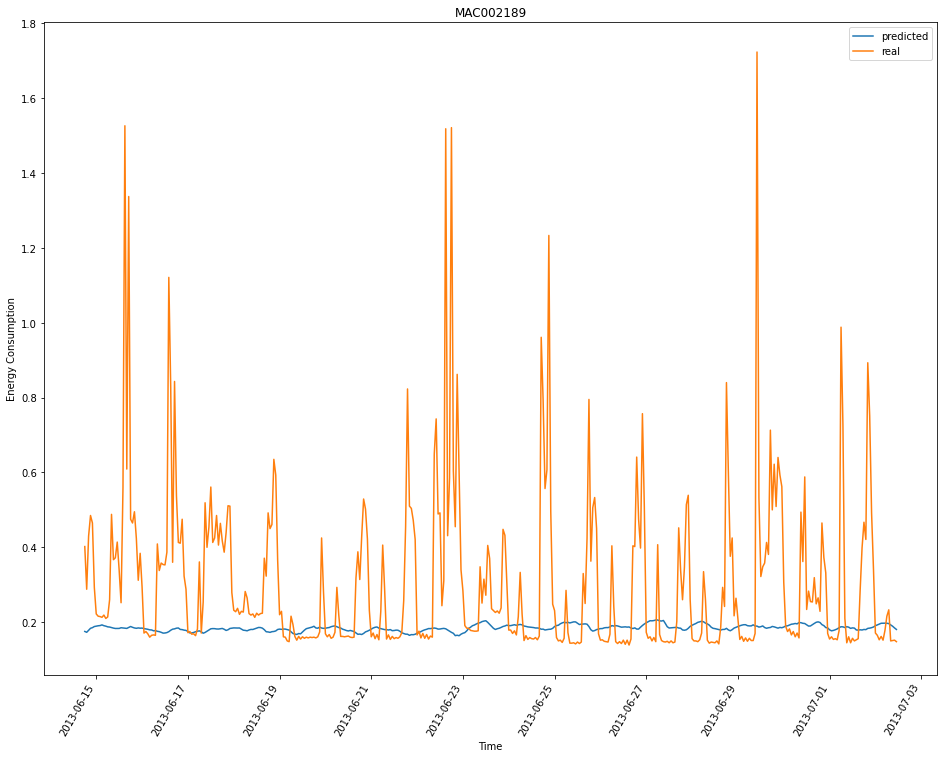

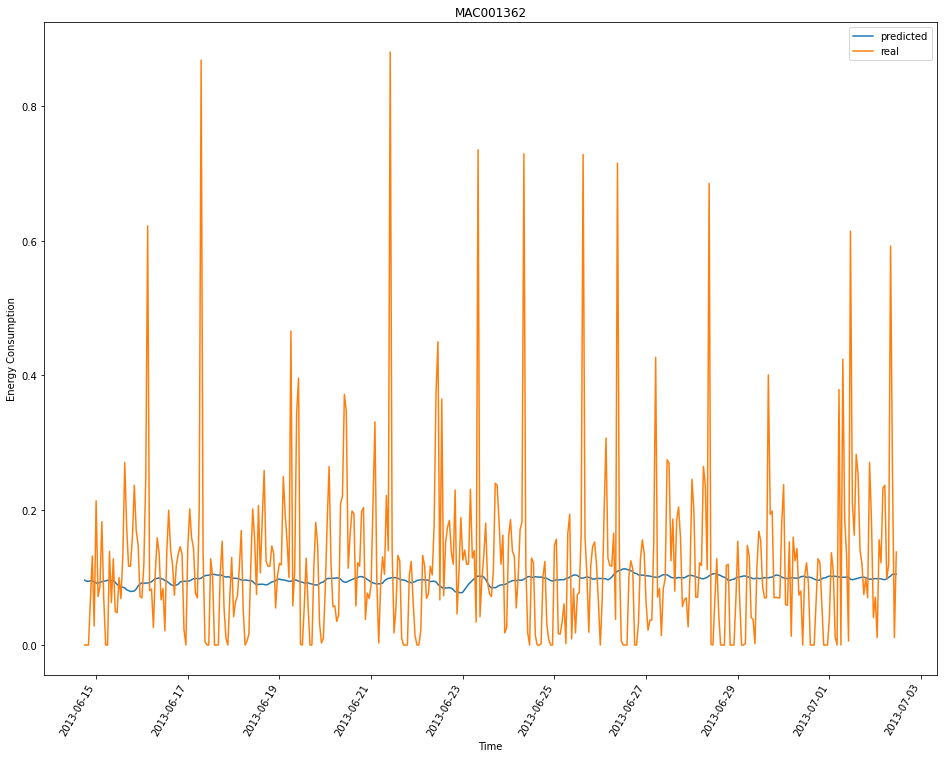

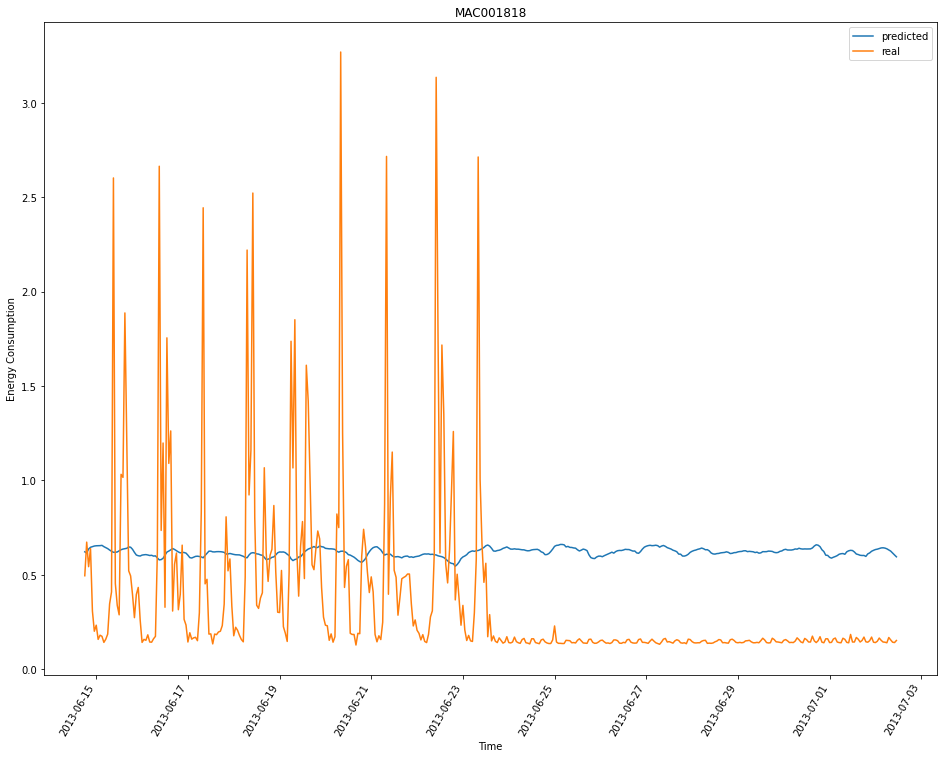

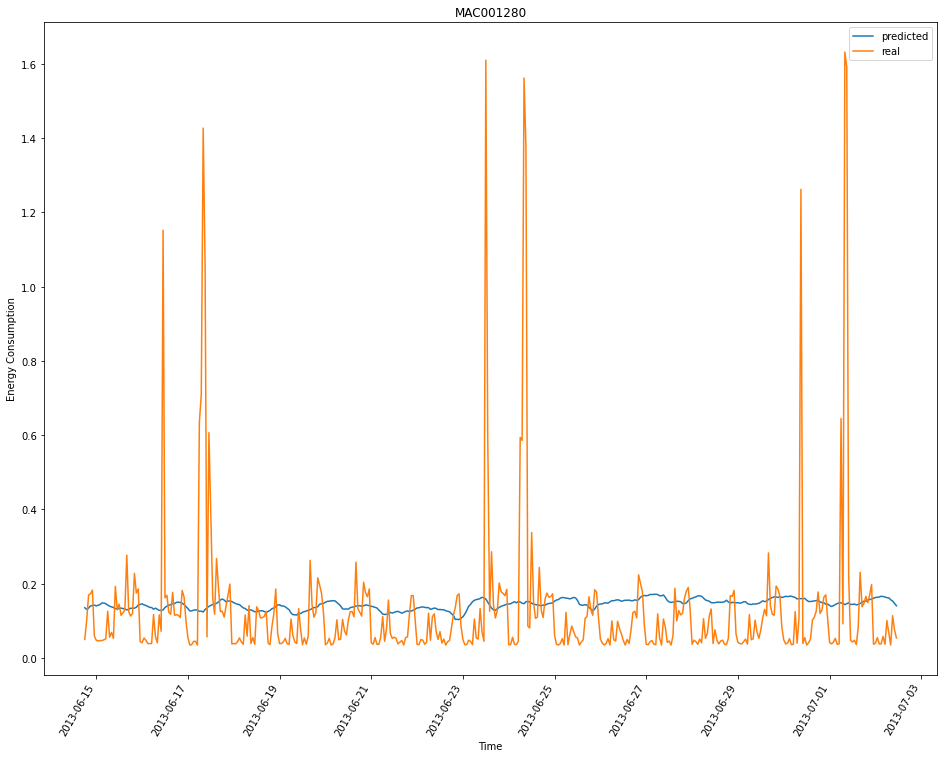

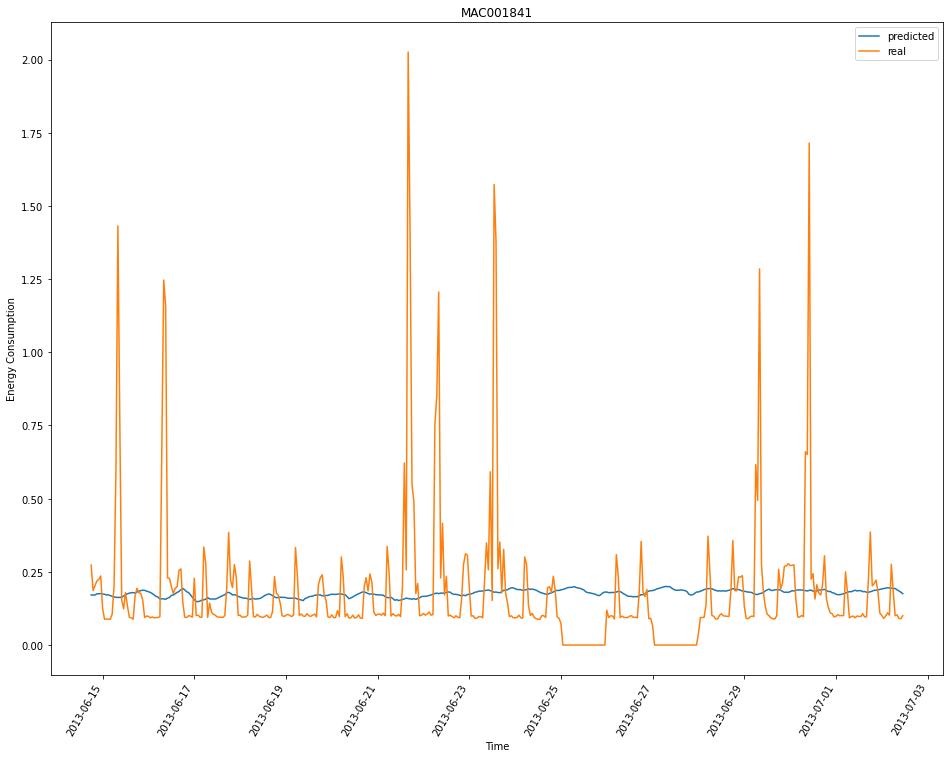

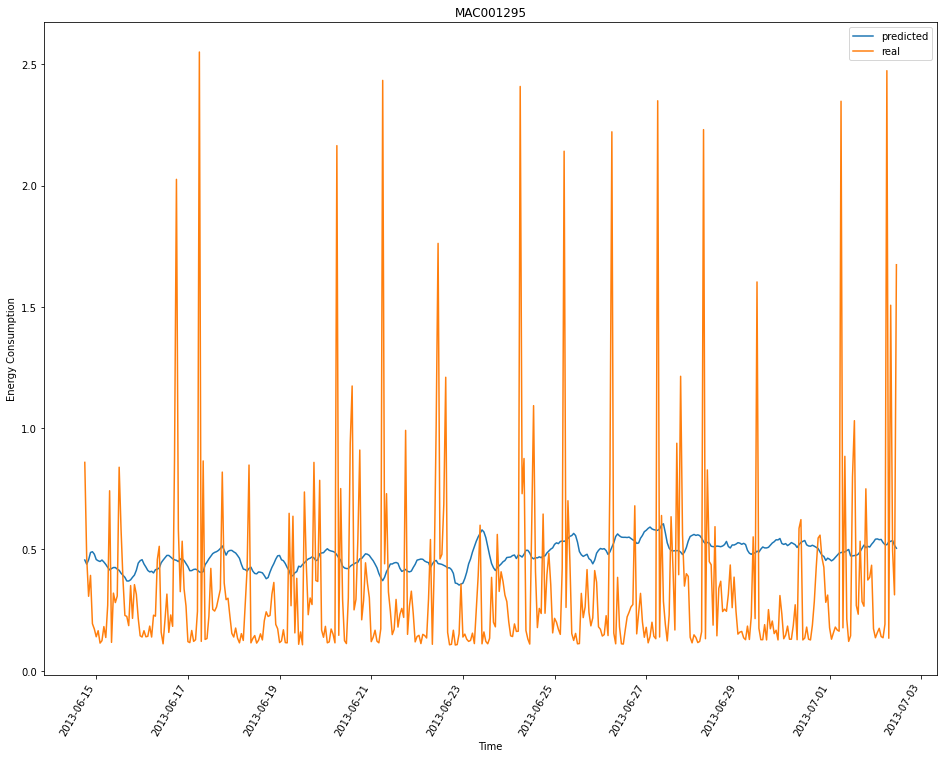

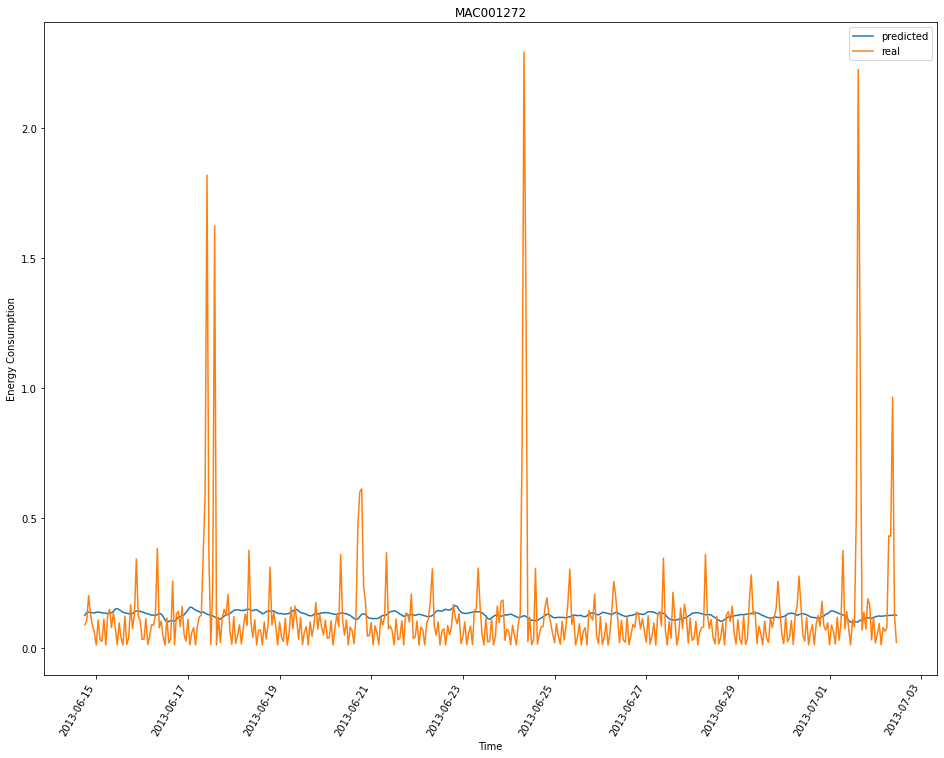

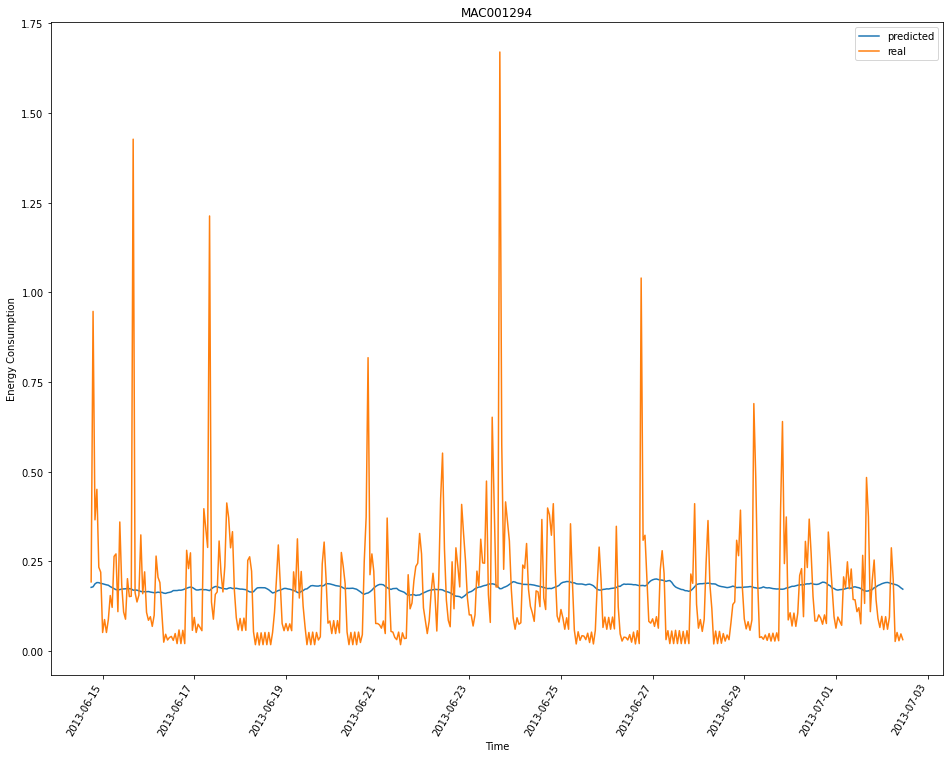

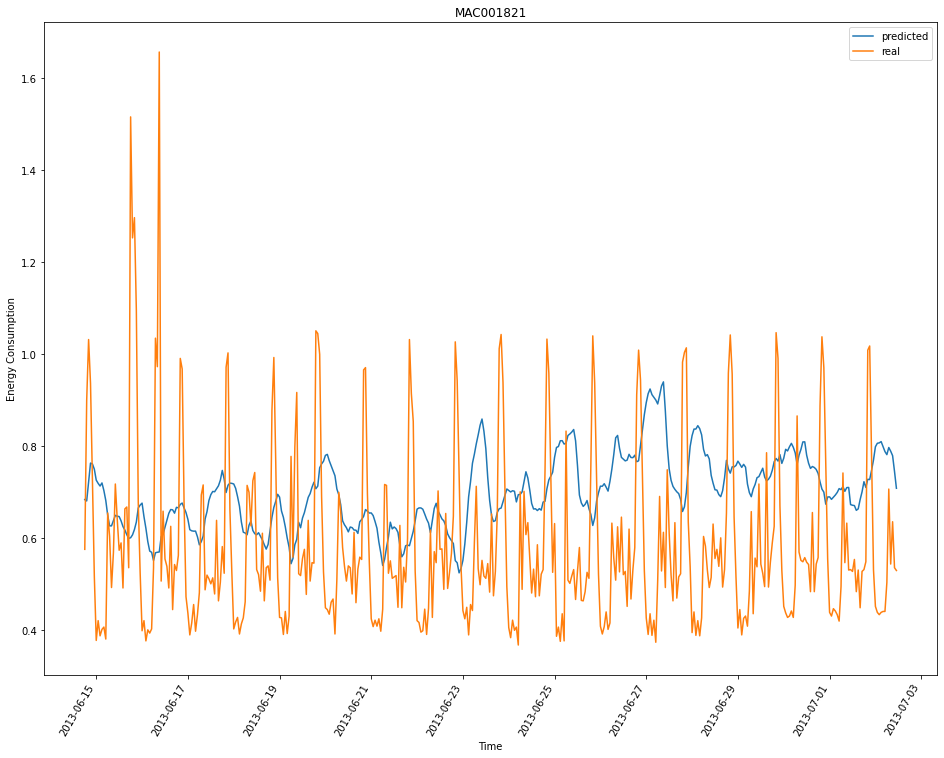

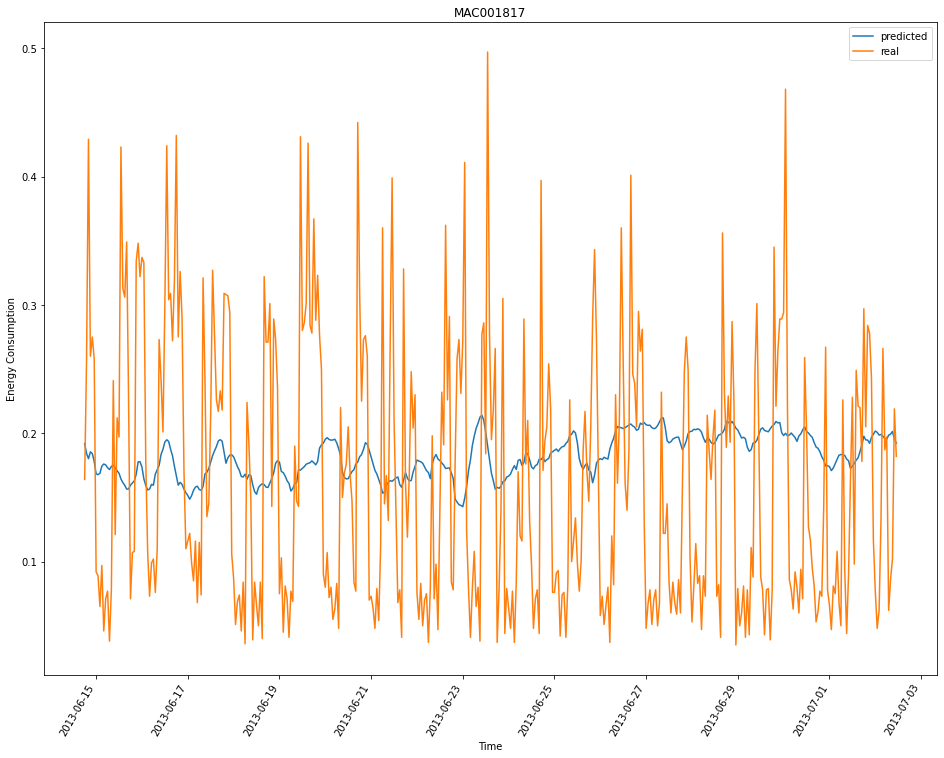

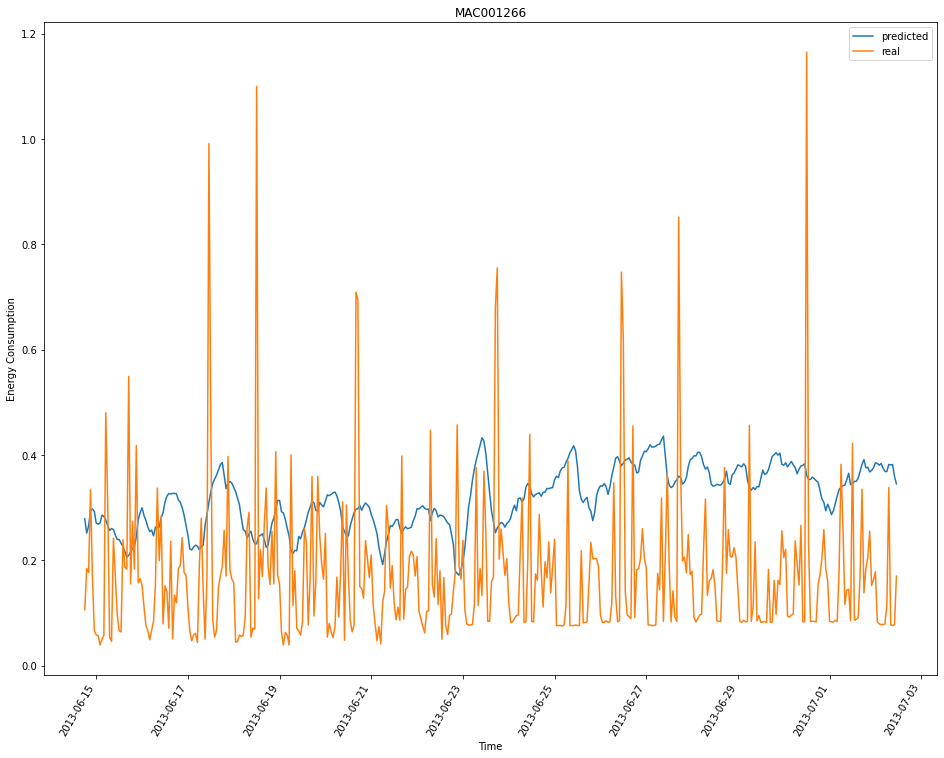

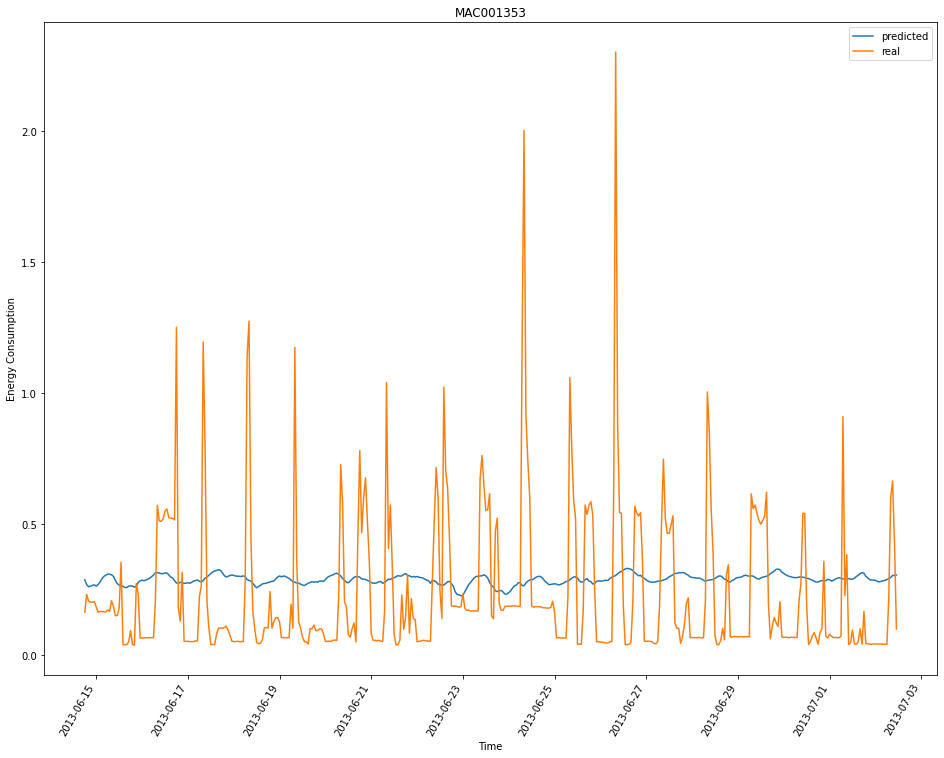

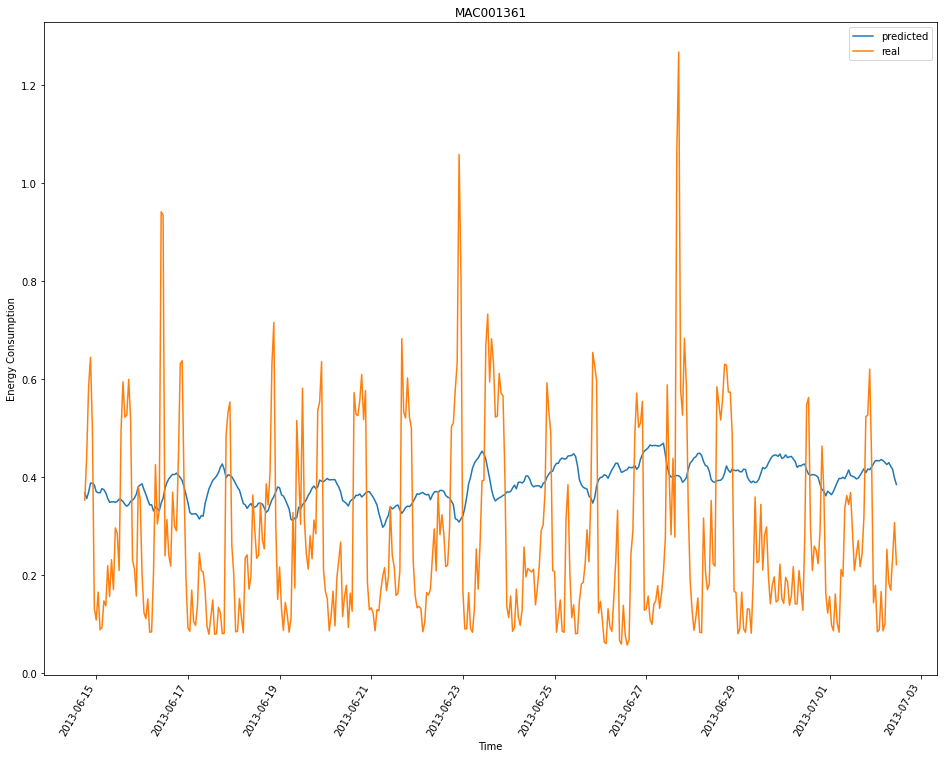

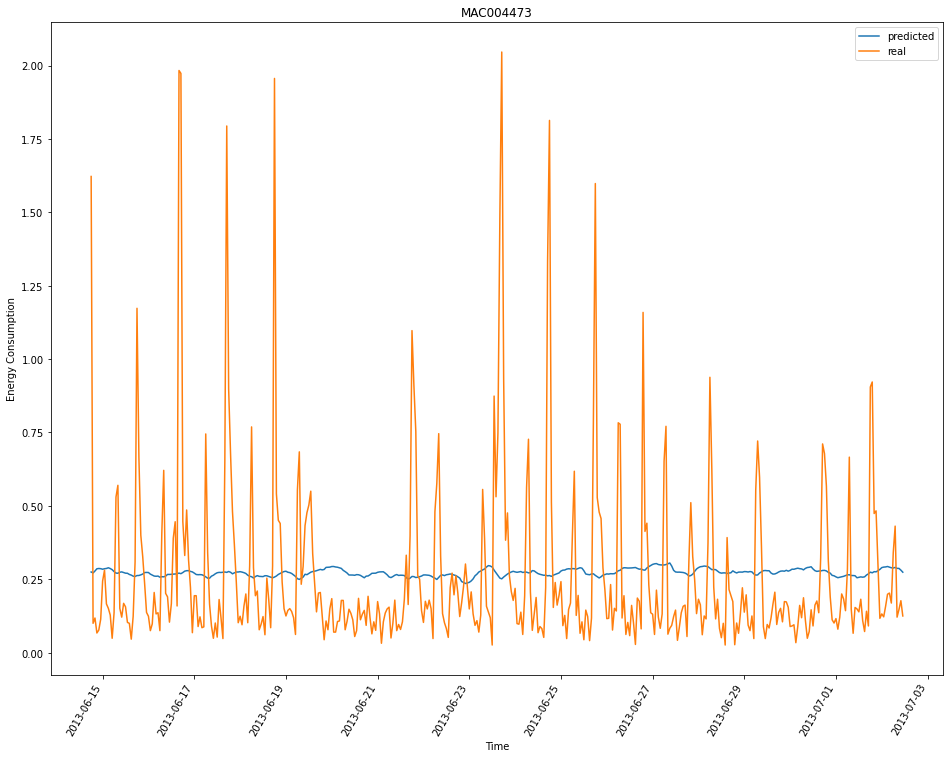

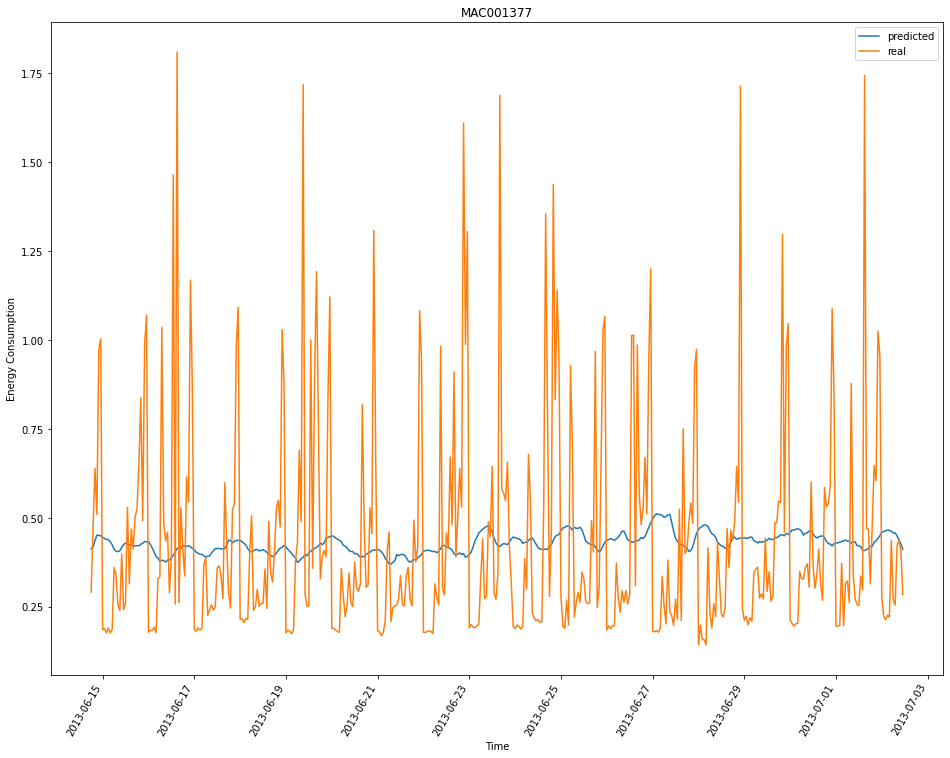

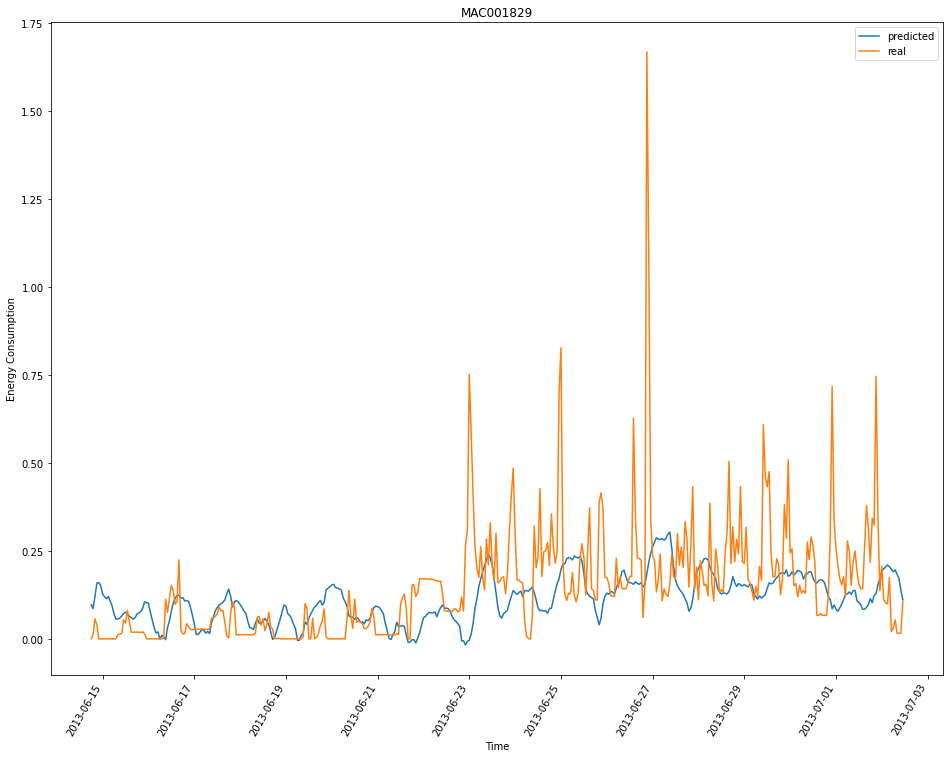

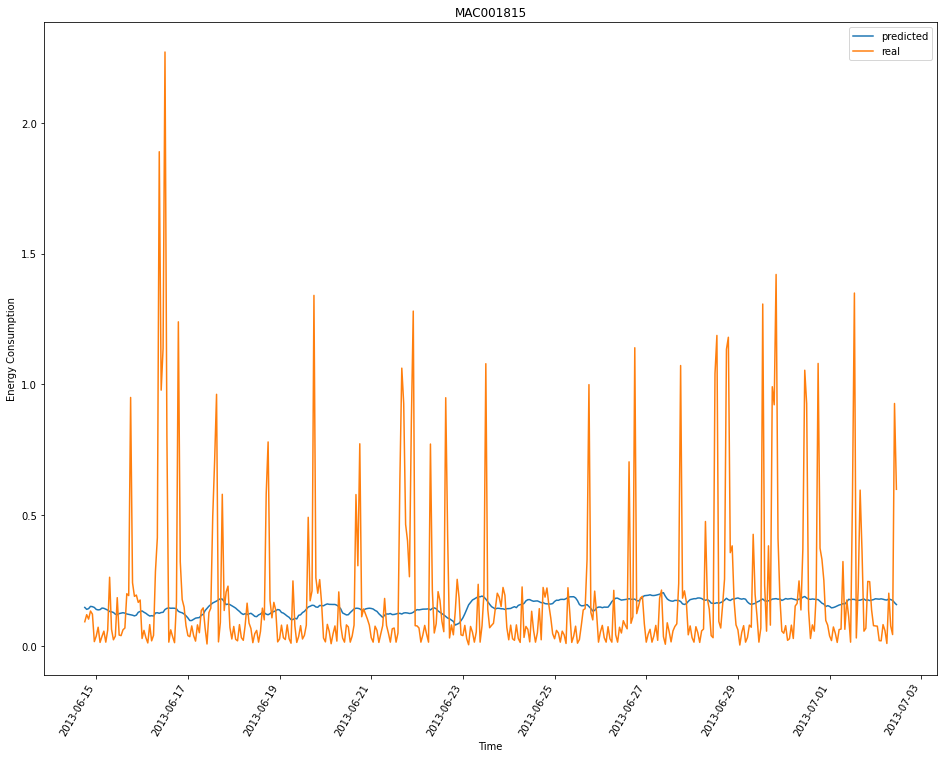

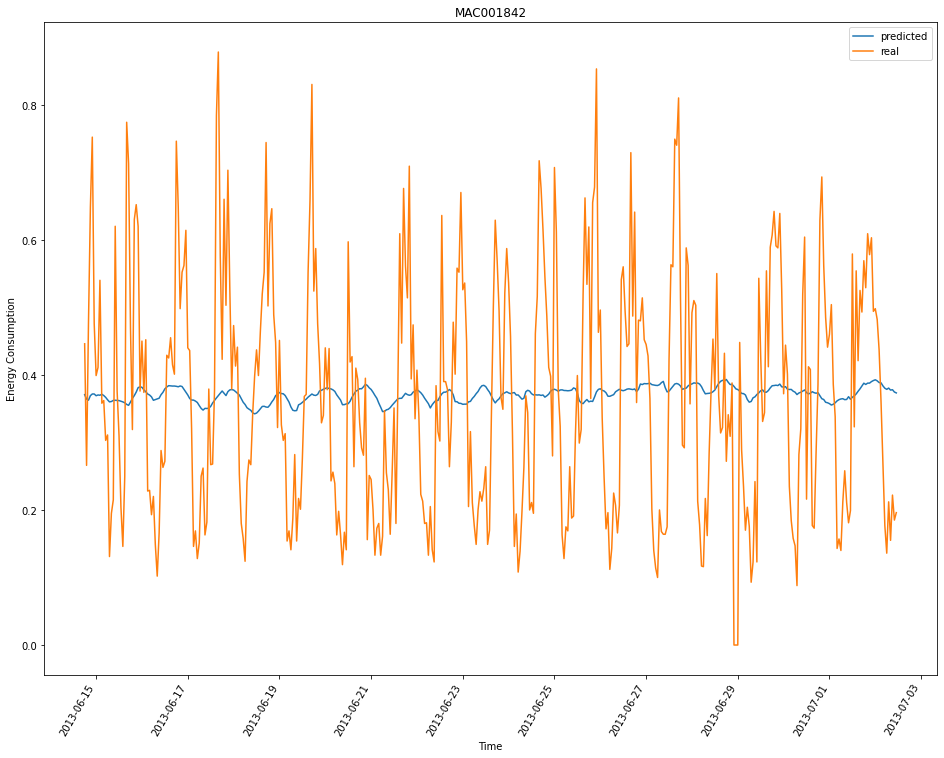

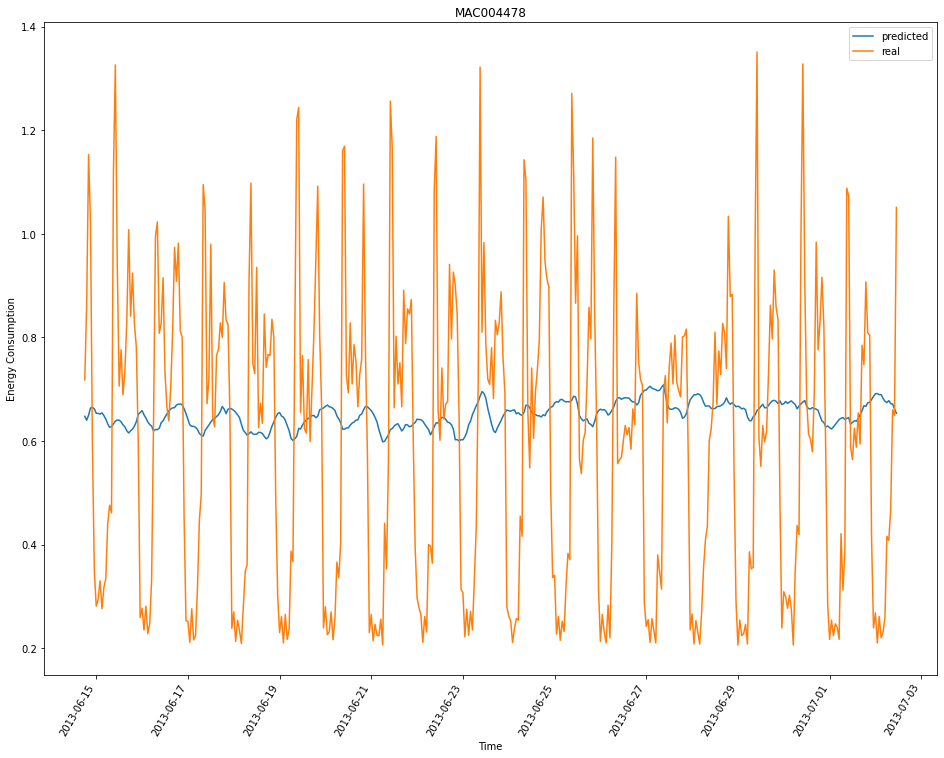

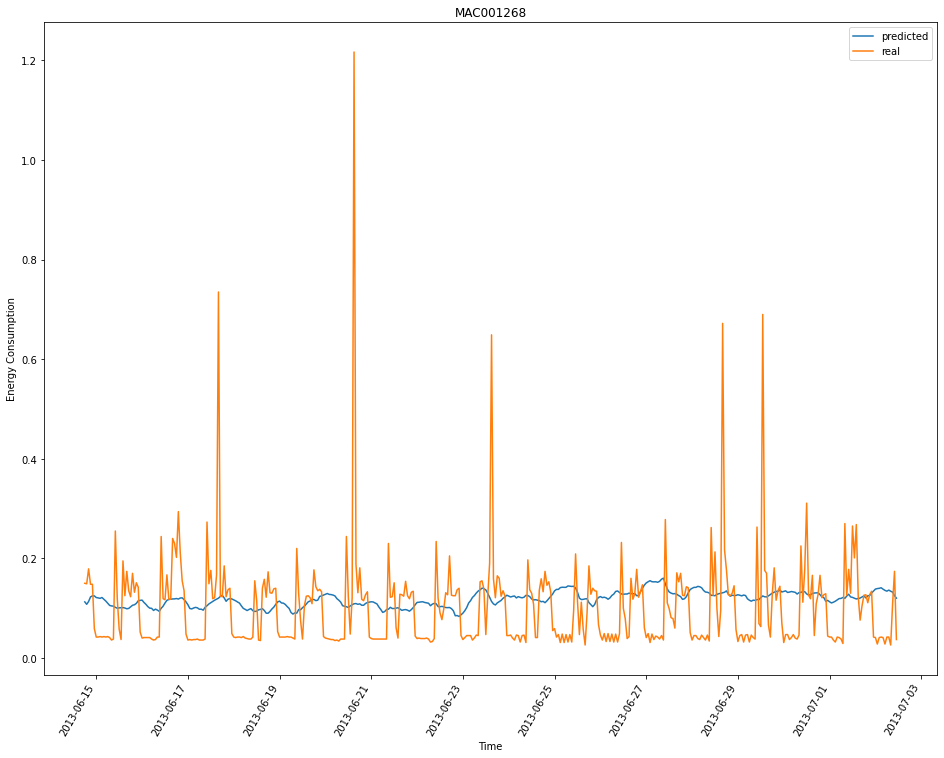

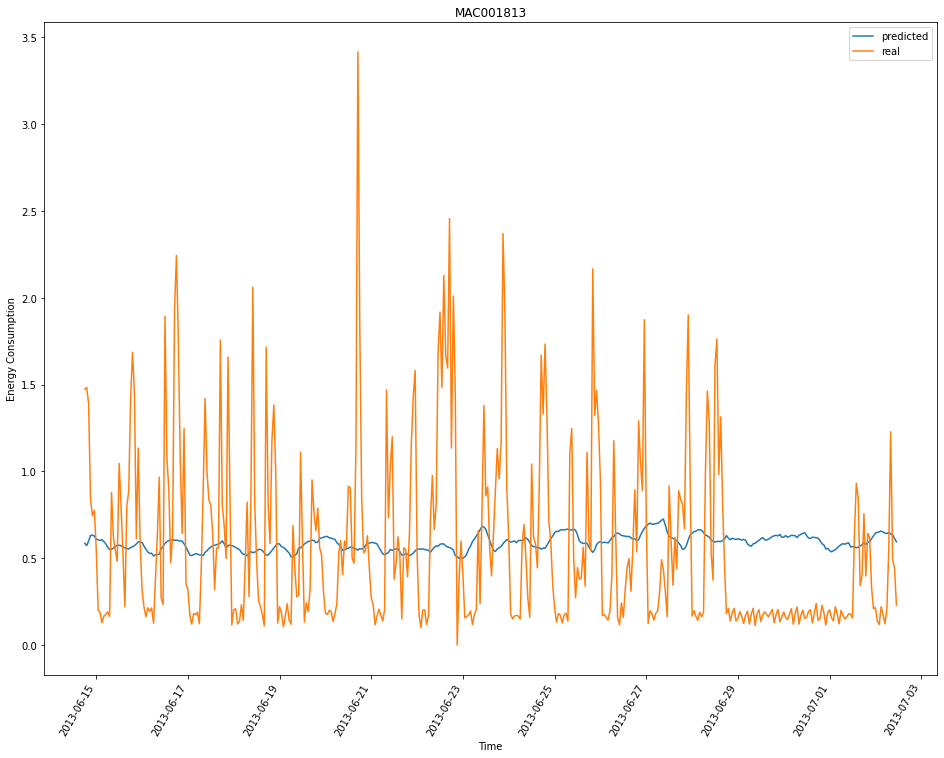

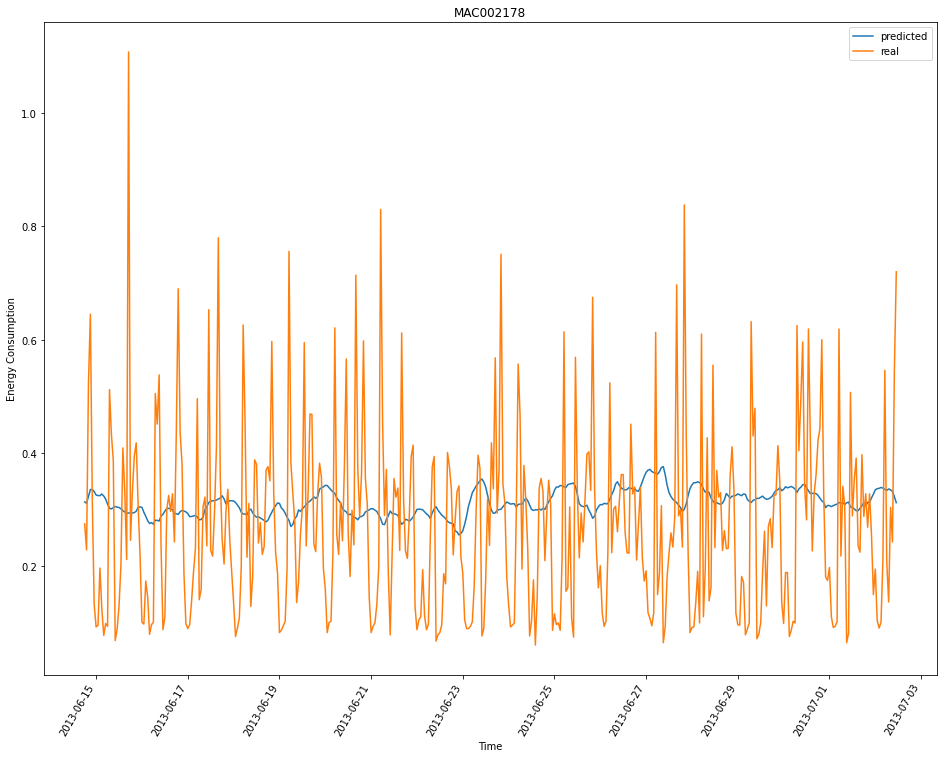

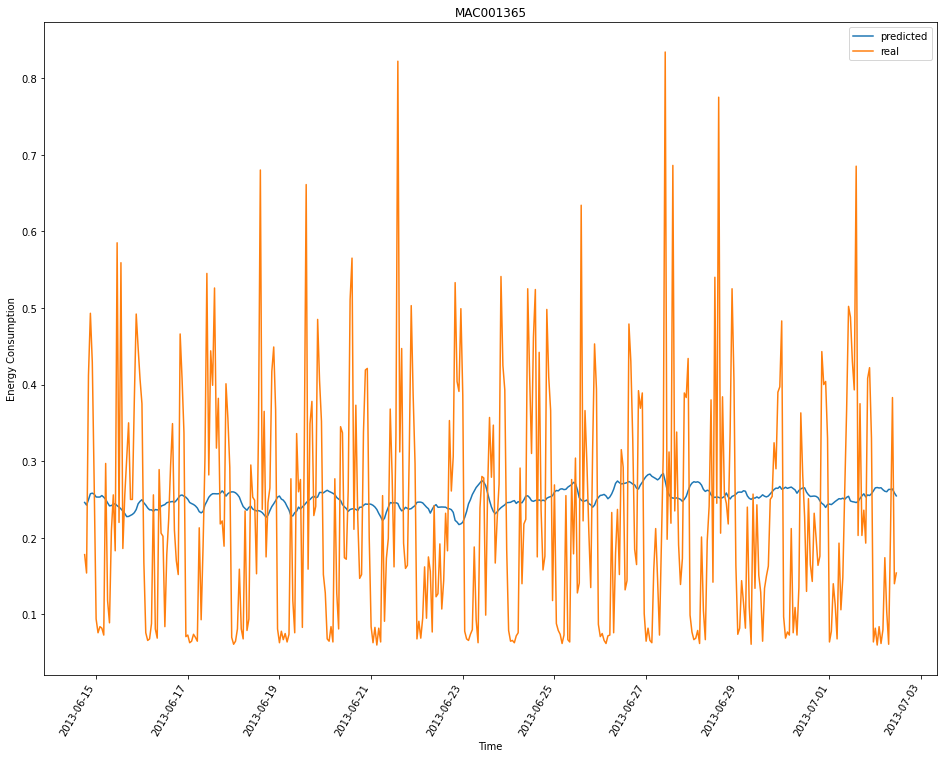

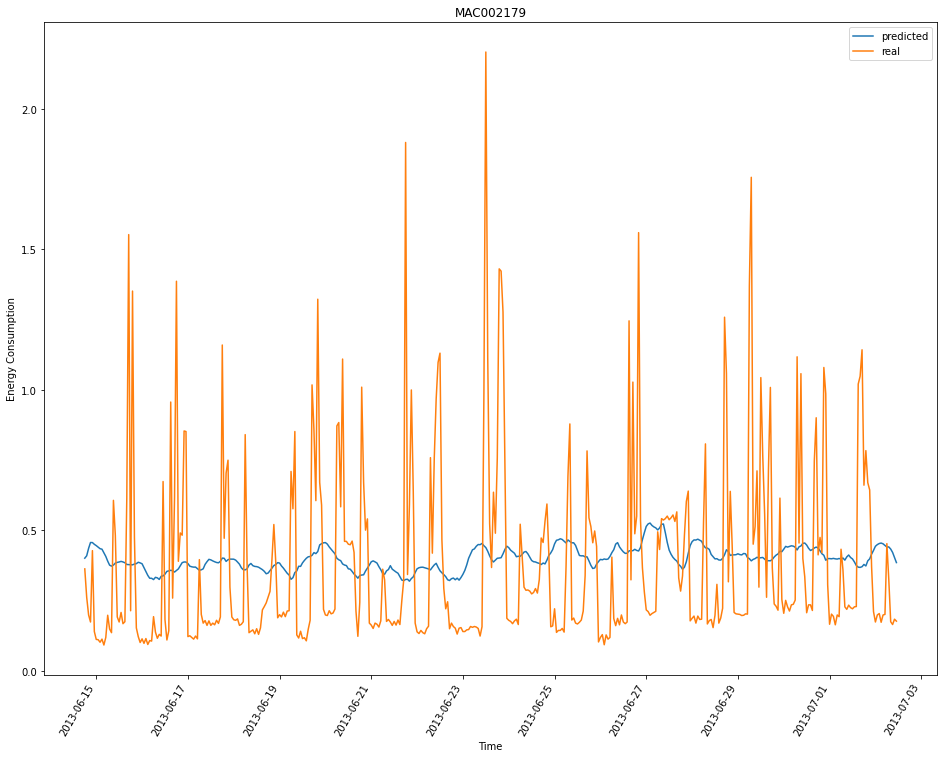

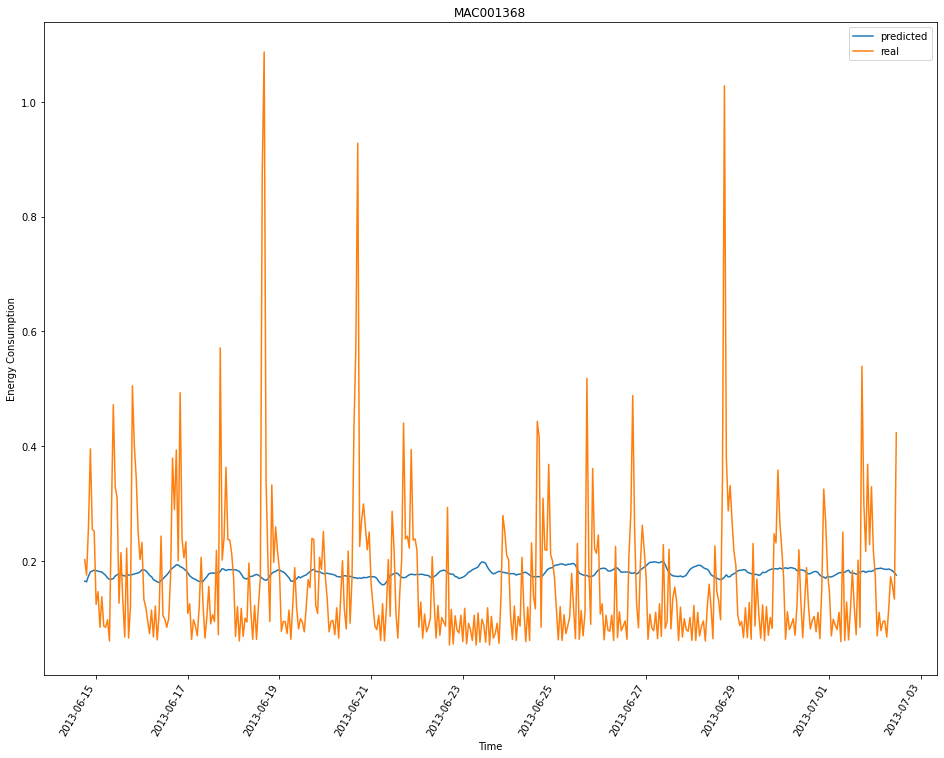

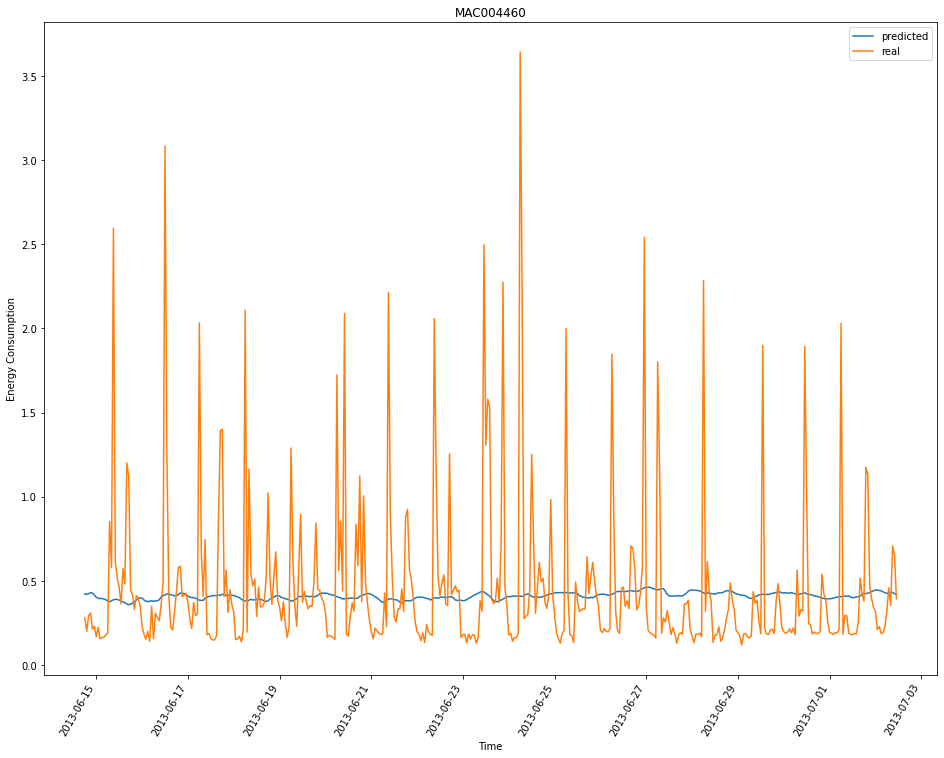

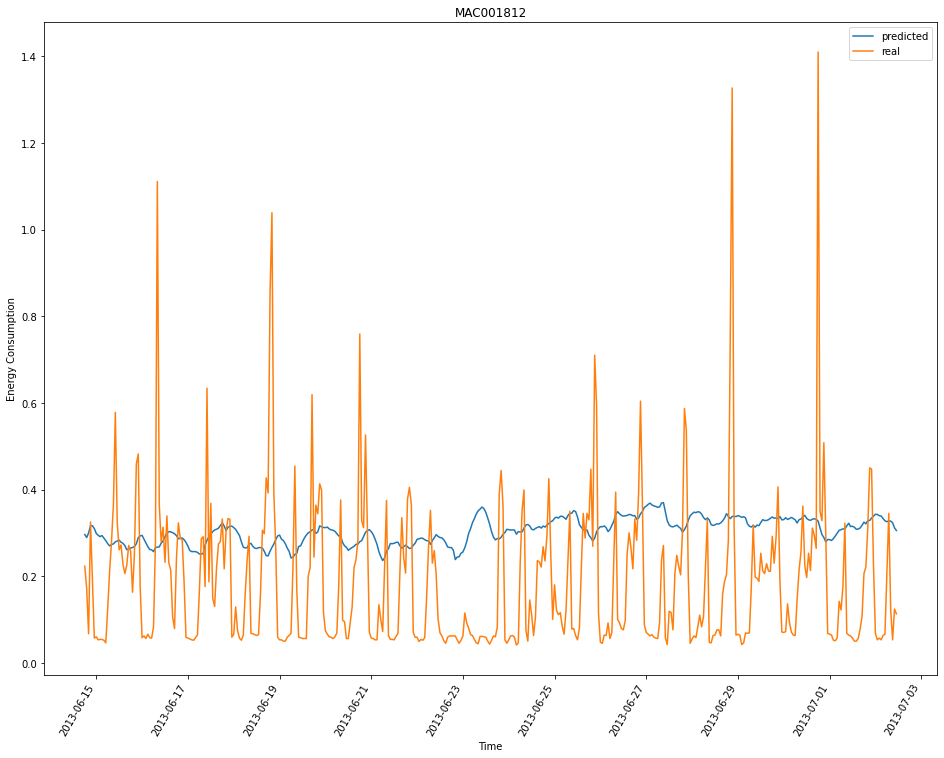

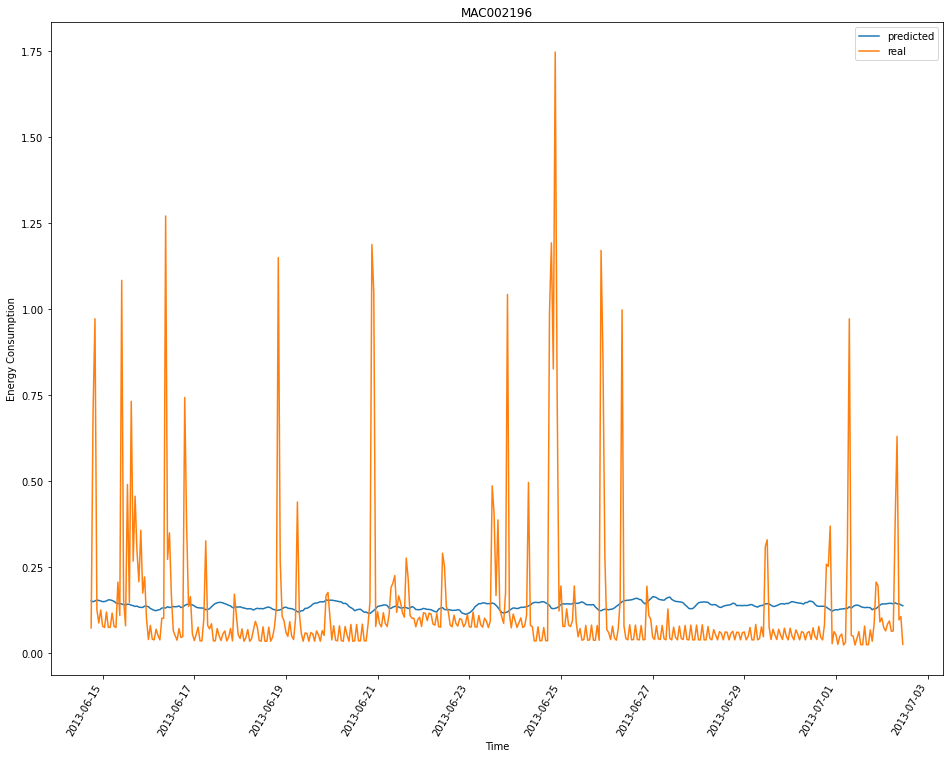

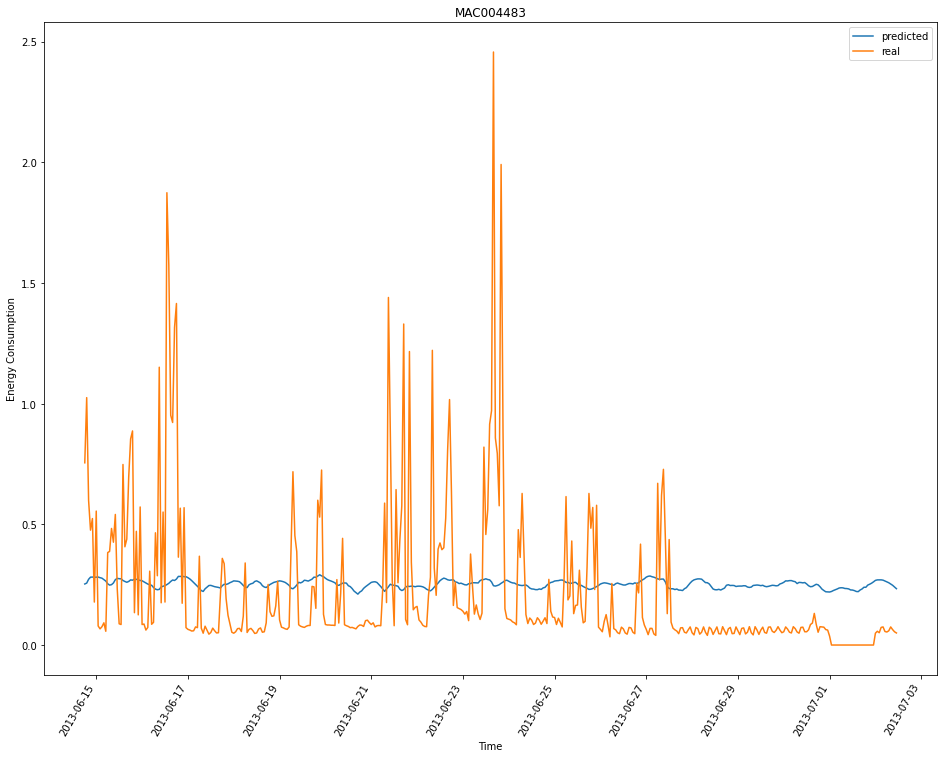

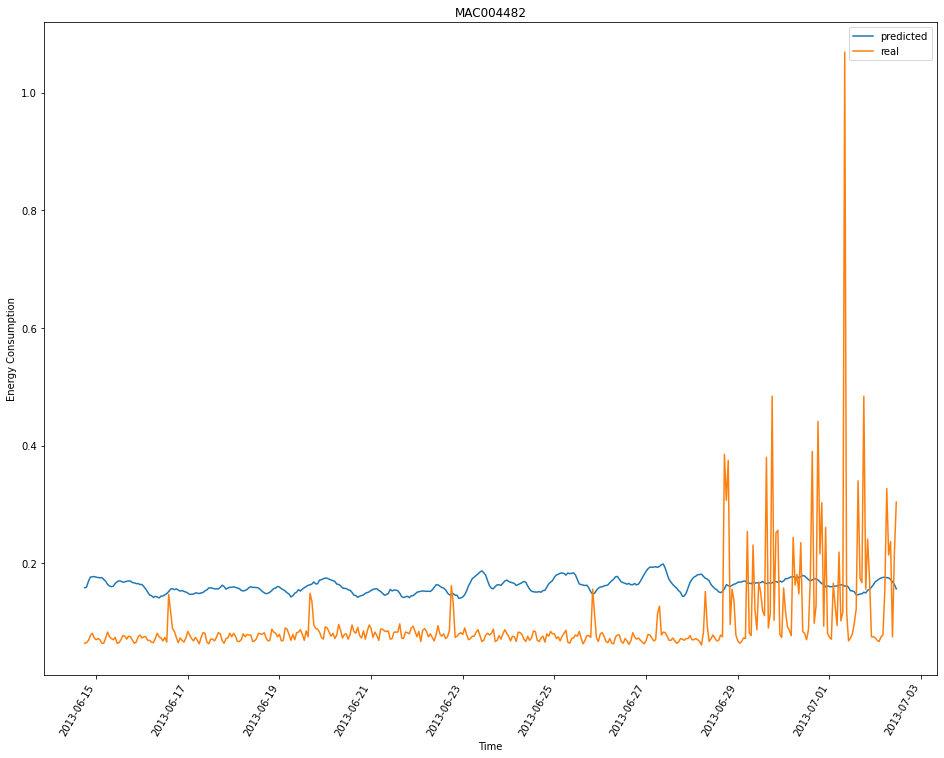

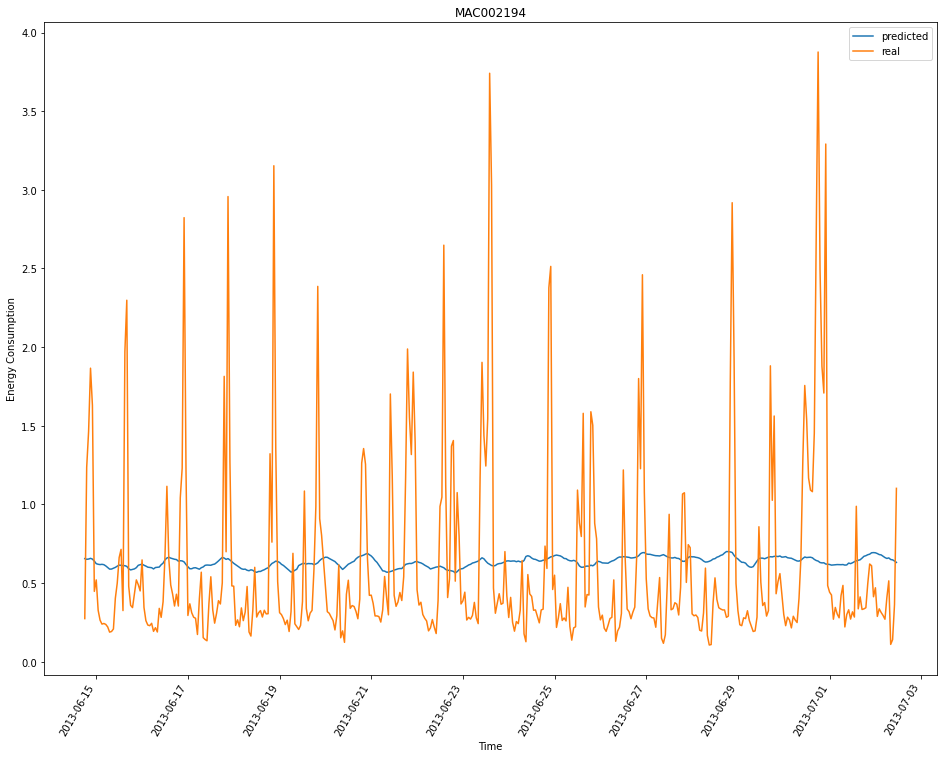

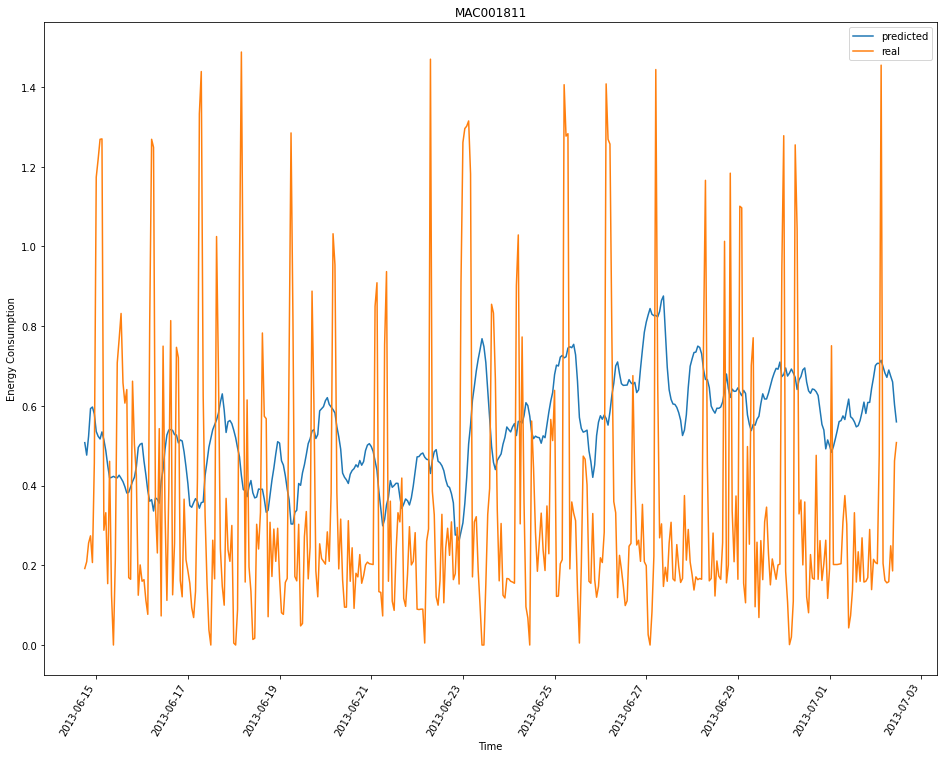

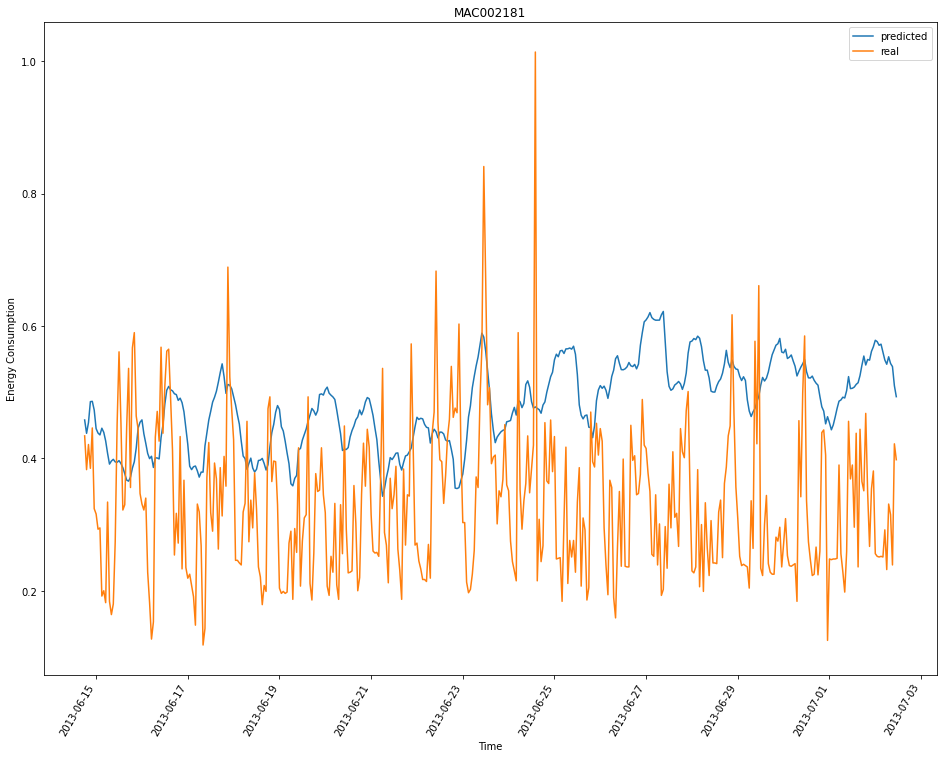

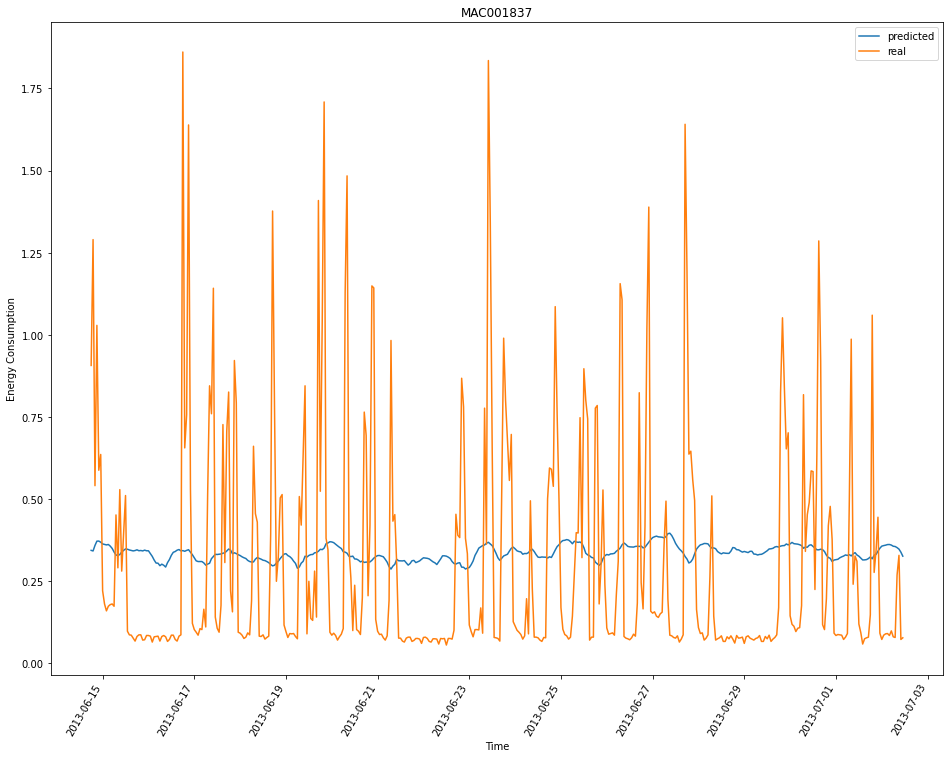

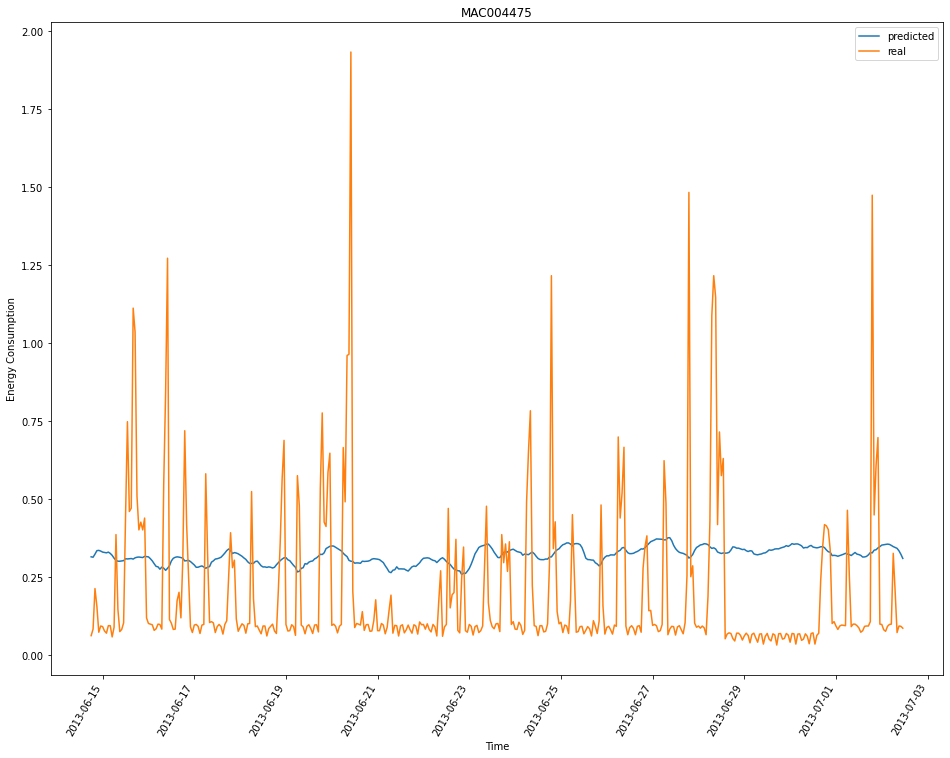

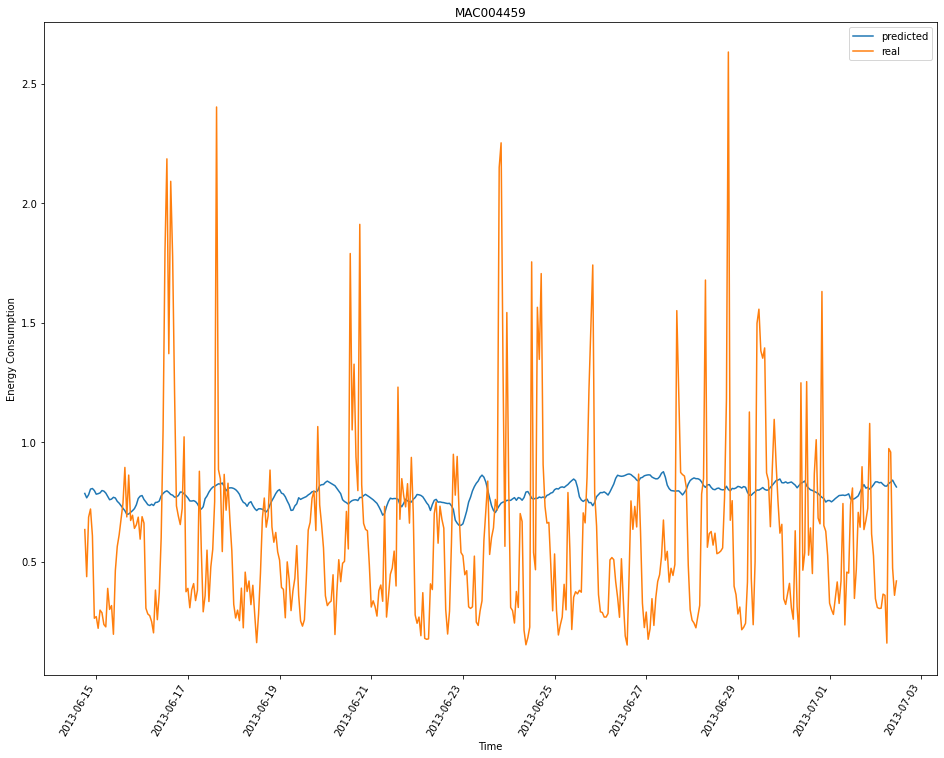

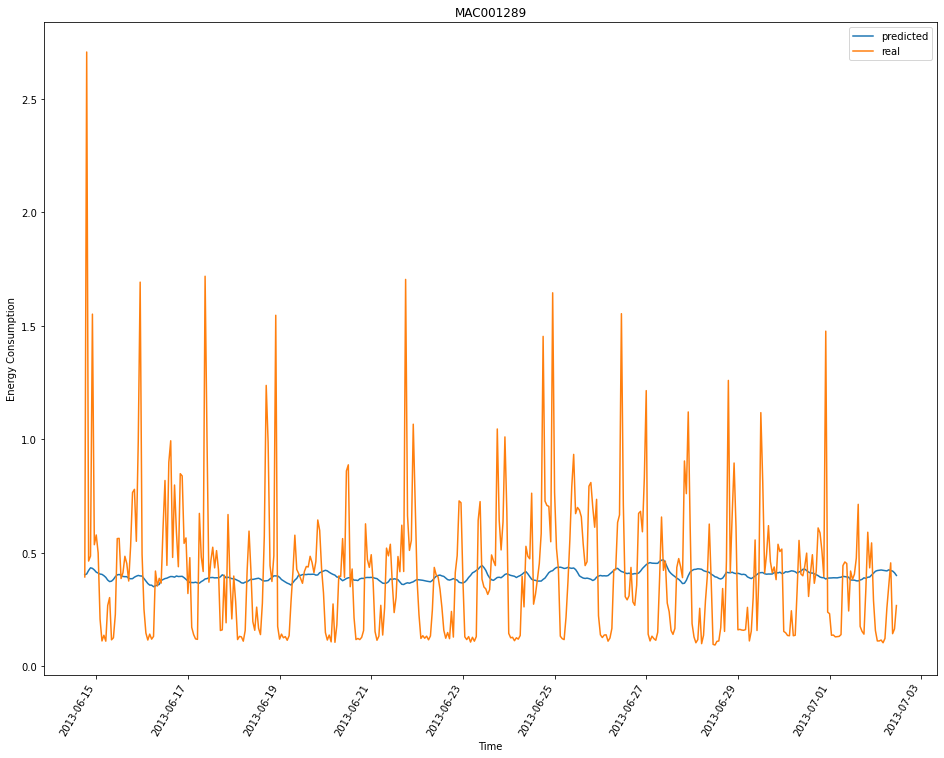

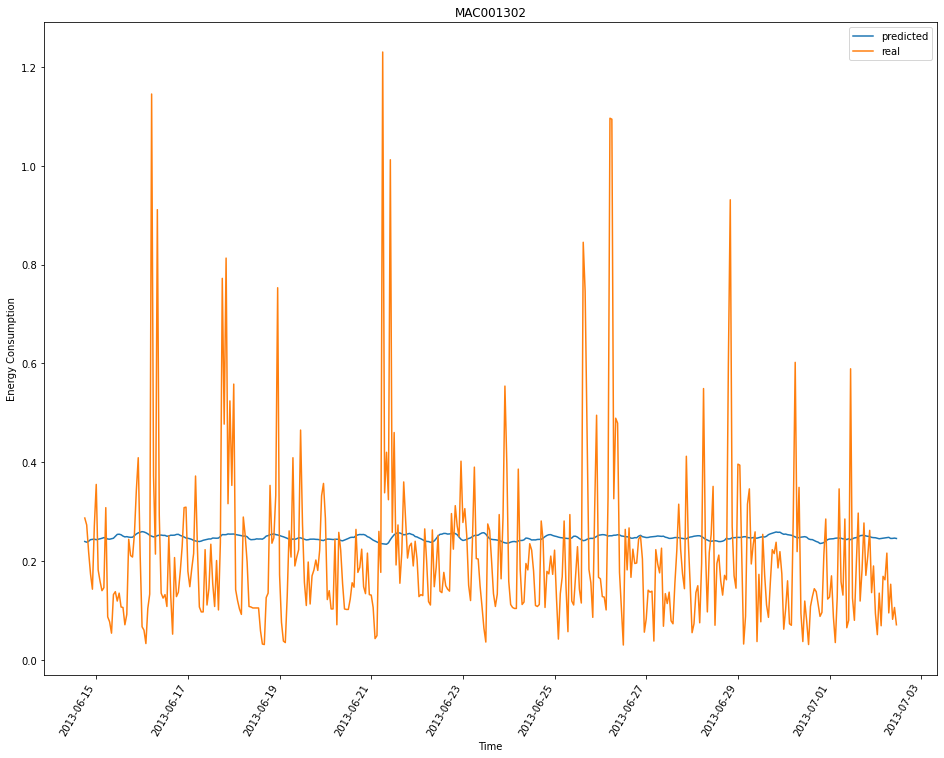

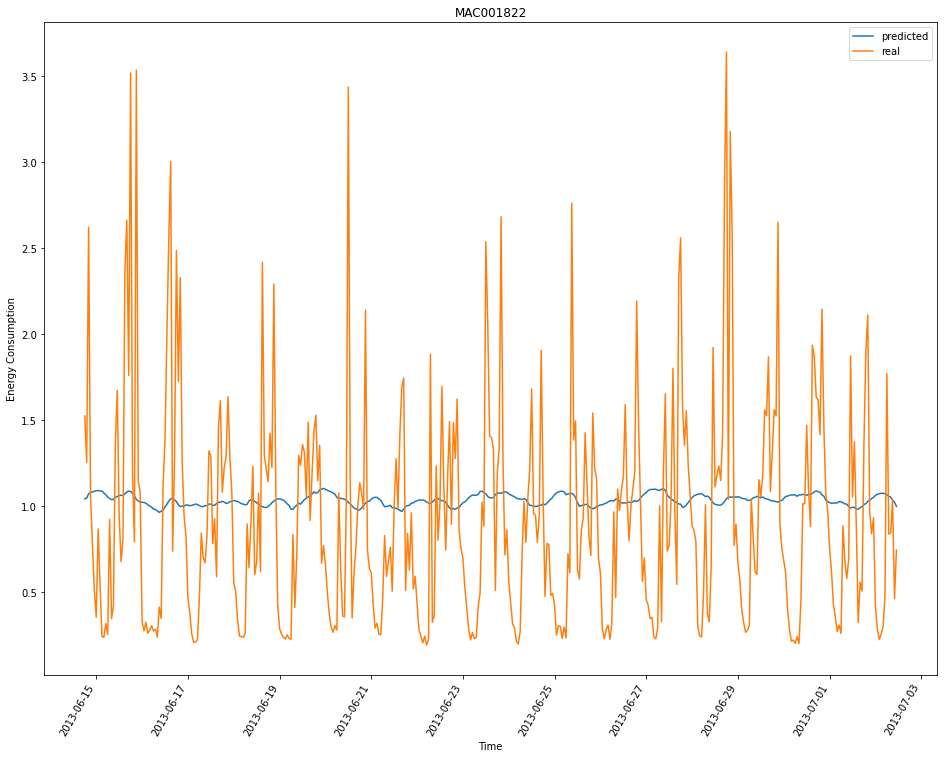

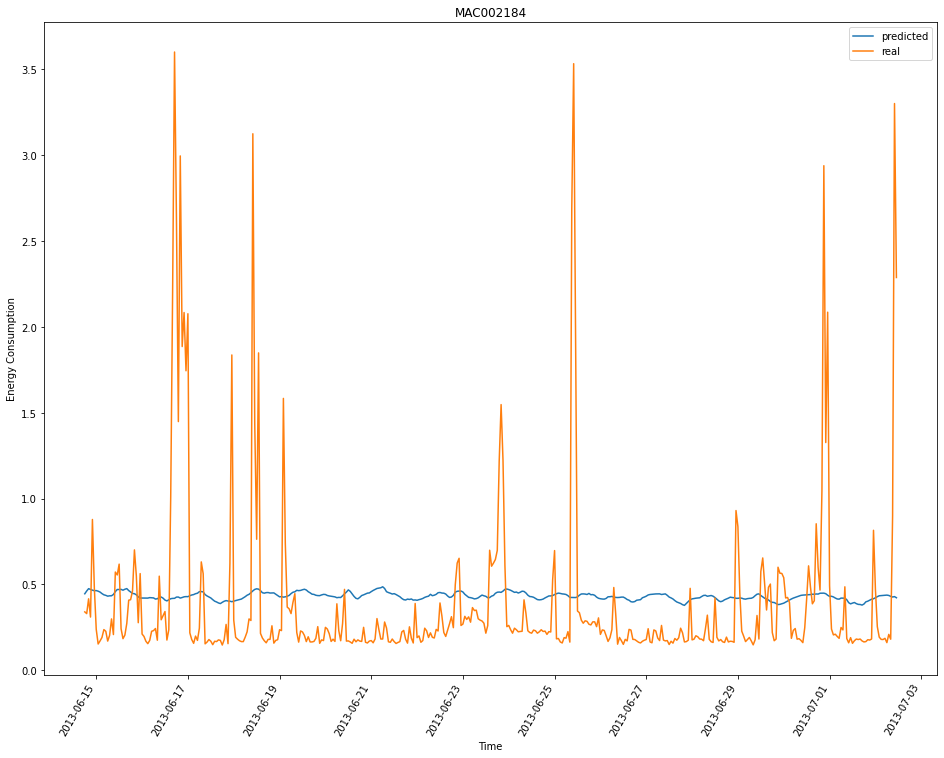

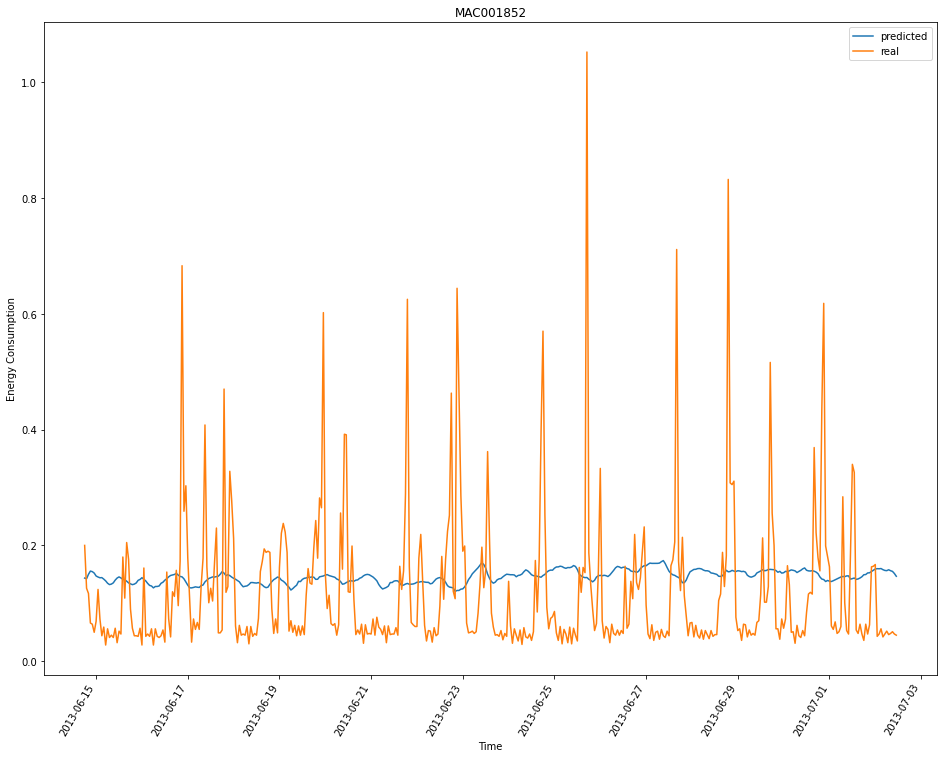

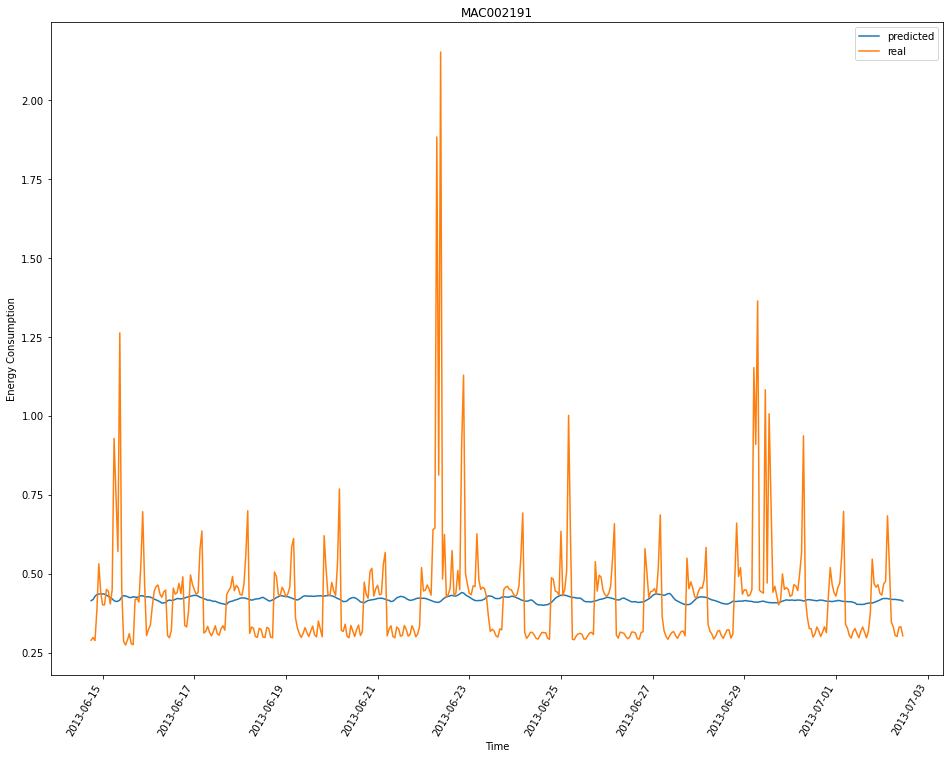

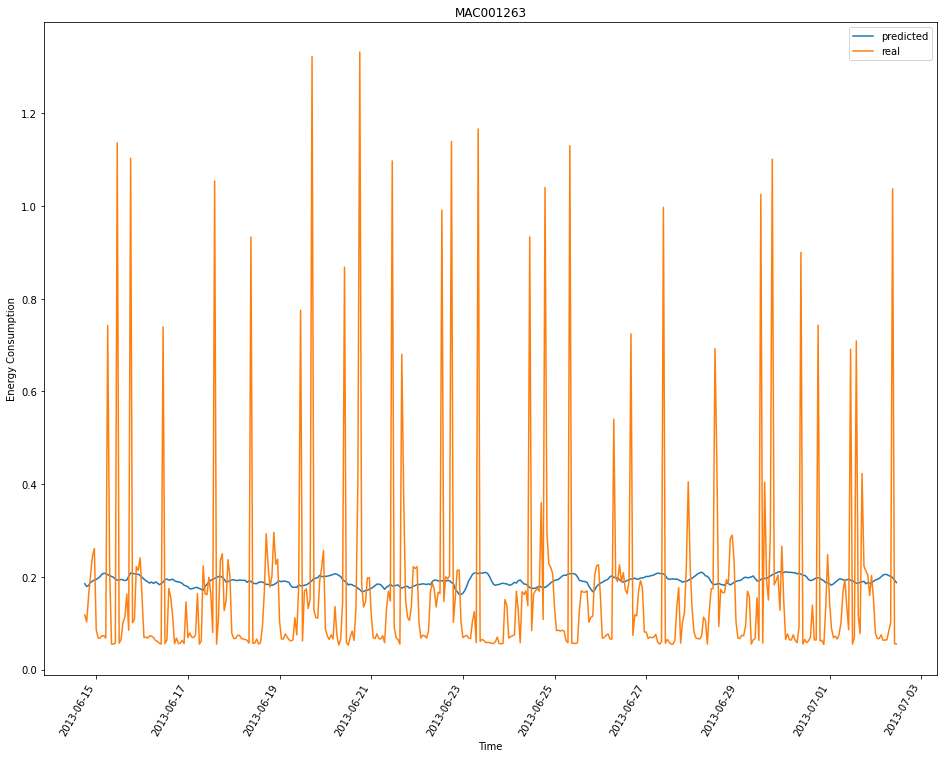

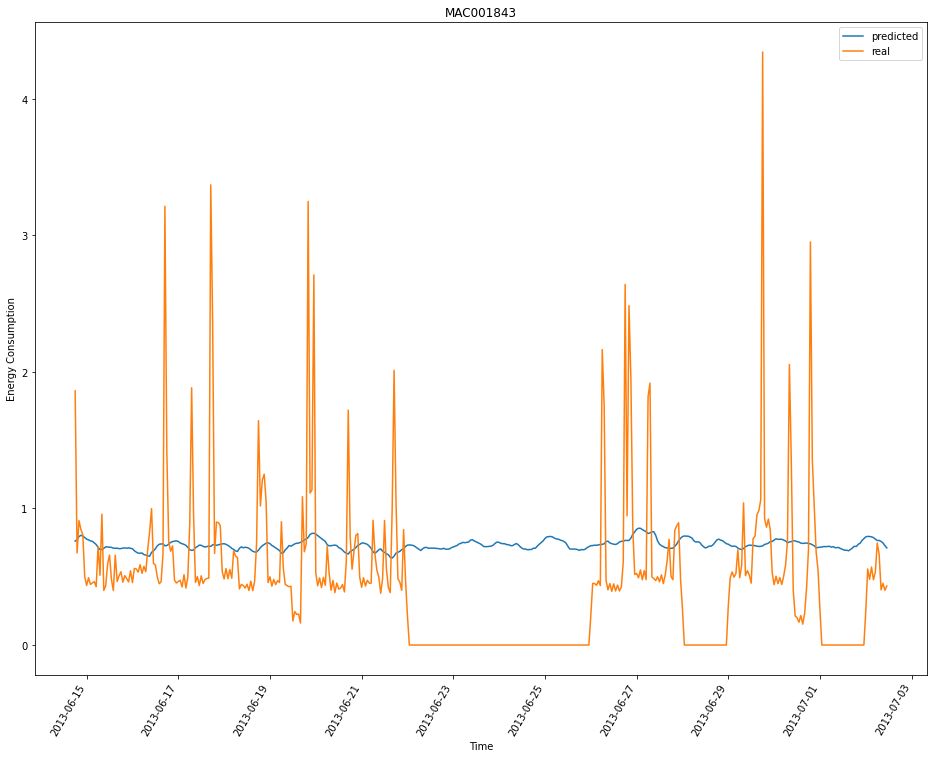

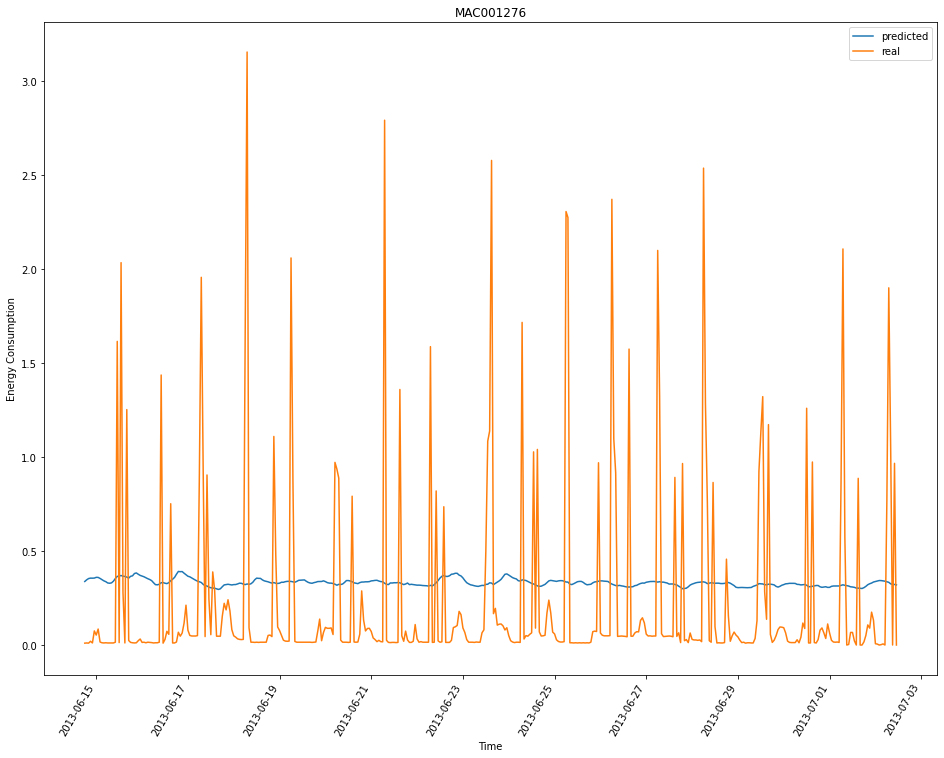

In [28]:
for i in range(50):

  #random_number = random.randint(0,NUMBER_OF_CLIENTS)
  key = shortlist_keys[i]
  pred = preds[key]
  true = test.iloc[TIME_WINDOW_SIZE:][key]

  x_ax = list(preds.index)
  mpl.rcParams['figure.figsize'] = (16, 12)

  plt.plot(x_ax, pred, label='predicted')
  plt.plot(x_ax, true, label='real')
  plt.xticks(rotation=60, ha='right')
  plt.ylabel("Energy Consumption")
  plt.xlabel("Time")
  plt.title(key)
  plt.legend()
  plt.show()
  plt.close()

It seems that there is no coincidence that the R2 value we got is really bad, most of the forecasts are just a little bit more complex than a constant line. Adding new features also did not help much.